In [1]:
import os
import numpy as np
import re
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from datetime import datetime as dt

#Path = r'/Users/luoqk/Desktop/Workspace/haodf-personal-website-statistics-crawler/' 
Path = r'/Volumes/Lacie/haodfCSV/'
os.chdir(Path)


Bad key text.latex.preview in file /Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95 

In [2]:
allNormal = pd.read_csv('reframed_original.csv', index_col=0)
#allNormal = pd.read_csv('reframed_original_7targets_opti.csv', index_col=0)
allNormal = pd.read_csv('38w_reframed_temporal_2.csv', index_col=0)
#reframed_original_7targets.csv
#chronicRecord_38w_2_g4
#chronicRecord_38w_2_g3
#chronicRecord_38w_2_g2
#chronicRecord_38w_2_g1

chronicItem = pd.read_csv('chronicRecord_38w_2_g6.csv', index_col=0)

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (23,25,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
len(allNormal)

383278

In [8]:
allNormal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383278 entries, 0 to 383277
Data columns (total 32 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           383278 non-null  int64  
 1   lastMod         383278 non-null  object 
 2   askList         381038 non-null  object 
 3   answerList      383269 non-null  object 
 4   checkInList     383278 non-null  object 
 5   complaint       383277 non-null  object 
 6   record          346164 non-null  object 
 7   advice          347277 non-null  object 
 8   consultingType  383278 non-null  object 
 9   patientVote     383278 non-null  object 
 10  onlineCons      383278 non-null  object 
 11  askLagTotal     383278 non-null  int64  
 12  answerLagTotal  383278 non-null  int64  
 13  checkInLag      383273 non-null  object 
 14  checkInTitle    383273 non-null  object 
 15  checkInType     383273 non-null  object 
 16  withOffLine     383278 non-null  int64  
 17  timesCheck

In [6]:
# chronicItem = pd.read_csv('chronicItem_indexed_Xt.csv', index_col=0)
chronicItem = pd.read_csv('tangniaobingRecord.csv', index_col=0)
#chronicItem = pd.read_csv('chronicRecord_38w.csv', index_col=0)

In [16]:
len(chronicItem)

14600

In [6]:
#allNormal = pd.read_csv('chronicAnswerList_38w.csv', index_col=0)

# oData = pd.read_csv('reframed_original.csv', index_col=0)
# reframed_dtb.csv
# reframed_chi.csv

In [11]:
ind_chronic = list(chronicItem.index)

chronicItem2 = allNormal.iloc[[i in ind_chronic for i in allNormal.index],:]
#chronicItem.to_csv('chronicItem_indexed.csv')
ind_chronic = list(chronicItem2.index)

In [12]:
X = chronicItem2.copy()
# X.fillna(0, inplace=True)

In [13]:
# senti from physician answer content
SentiFullS = pd.read_csv('sentiS_38w.csv')
SentiFullC = pd.read_csv('sentiC_38w.csv')
SentiS = SentiFullS.iloc[[i for i in ind_chronic],:]['sentiS']
SentiC = SentiFullC.iloc[[i for i in ind_chronic],:]['sentiC']
X = pd.concat([SentiS, SentiC, X], axis=1)

In [ ]:
# aaa = pd.read_csv('chronicItem_indexed_Xt.csv', index_col=0)
# for i in aaa.columns:
#     print(i, pd.Categorical(pd.Categorical(aaa[i]).unique()))

In [14]:
def chi2(arr):
    '''
    计算卡方值
    arr：频数统计表，二维numpy数组
    '''
    assert(arr.ndim == 2) 
    # assert断言是声明其布尔值必须为真的判定，如果发生异常就说明表达示为假。
    # 可以理解assert断言语句为raise-if-not，用来测试表示式，其返回值为假，就会触发异常。
    
    R_N = arr.sum(axis=1) # 计算每行总频数
    C_N = arr.sum(axis=0) # 计算每列总频数
    N = arr.sum() # 总频数
    
    E = np.ones(arr.shape)*C_N/N # 计算期望频数
    E = (E.T*R_N).T
    square = (arr-E)**2/E
    square[E==0] = 0 # 当期望频数为0时，作为分母无意义，不计入卡方值
    
    v = square.sum() # 卡方值
    return v

def chiMerge(df,col,target,max_groups = None,threshold = None):
    '''
    卡方分箱
    df: pandas DataFrame 数据集
    col: 需要分箱的变量名（数值型）
    target：类标签
    max_groups: 最大分组数
    threshold： 卡方阈值，如果未指定max_groups，默认使用置信度95%设置threshold
    return：包括各组的起始值的列表
    '''
    freq_tab = pd.crosstab(df[col],df[target])
    
    # 转成numpy数组用于计算
    freq = freq_tab.values
    
    # 初始分组切分点，每个变量值都是切分点，每组中只包含一个变量值
    # 分组区间是左闭右开的，如cutoffs = [1,2,3]，表示区间，[1,2),[2,3).[3,3+)
    cutoffs = freq_tab.index.values
    
    # 如果没有指定最大分组
    if max_groups is None:
        # 如果没有指定卡方阈值，就以95%的置信度（自由度为类数目-1）设定阈值
        if threshold is None:
            # 类数目
            cls_num = freq.shape[-1]
            threshold = chi2.isf(0.05,df = cls_num-1)
    
    while True:
        minvalue = None
        minidx = None
        # 从第一组开始，依次计算两组卡方值，并判断是否小于当前最小的卡方
        for i in range(len(freq)-1):
            v = chi2(freq[i:i+2])
            if minvalue is None or minvalue > v: # 小于当前最小卡方，更换最小值
                minvalue = v
                minidx = i
        
        # 如果最小卡方值小于阈值，则合并最小卡方值的相邻两组，并继续循环
        if (max_groups is not None and max_groups < len(freq)) or (threshold is not None and minvalue < threshold):
            # minidx 后一行合并到minidx
            tmp = freq[minidx] + freq[minidx+1]
            freq[minidx] = tmp
            # 删除minidx后一行
            freq = np.delete(freq,minidx+1,0)
            # 删除对应的切分点
            cutoffs = np.delete(cutoffs,minidx+1,0)
            
        else: # 最小卡方值不小于阈值，停止合并
            break
    return cutoffs

def value2group(x,cutoffs):
    '''
    将变量的值转换成相应的组
    x: 需要转换到分组的值
    cutoffs：各组的起始值
    return： x对应的组，如group1，从group1开始

    '''
    # 切分点从小到大排序
    cutoffs = sorted(cutoffs)
    num_groups = len(cutoffs)
    # 异常情况：小于第一组的起始值，这里直接放到第一组
    # 异常值建议在分组之前先处理妥善
    if x < cutoffs[0]:
        return 'group1'
    
    for i in range(1,num_groups):
        if cutoffs[i-1] <= x <cutoffs[i]:
            return 'group{}'.format(i)
    # 最后一组，也可能会包括一些非常大的异常值
    return 'group{}'.format(num_groups)

def decision_tree_binning(x_value: np.ndarray, y_value: np.ndarray, max_bin=10) -> list:
    '''利用决策树获得最优分箱的边界值列表'''
    from sklearn.tree import DecisionTreeClassifier

    clf = DecisionTreeClassifier(
        criterion='entropy',  # “信息熵”最小化准则划分
        max_leaf_nodes=max_bin,  # 最大叶子节点数
        min_samples_leaf=0.05)  # 叶子节点样本数量最小占比
    clf.fit(x_value.reshape(-1, 1), y_value)  # 训练决策树
    #clf.fit(x_value, y_value)

    # 绘图
    import matplotlib.pyplot as plt
    from sklearn.tree import plot_tree
    plt.figure(figsize=(14, 12))  # 指定图片大小
    plot_tree(clf)
    plt.show()

    # 根据决策树进行分箱
    n_nodes = clf.tree_.node_count  # 决策树节点
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold

    # 开始分箱
    boundary = []
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])

    boundary.sort()

    min_x = x_value.min()
    max_x = x_value.max()
    # max_x = x_value.max() + 0.1  # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]
    return boundary

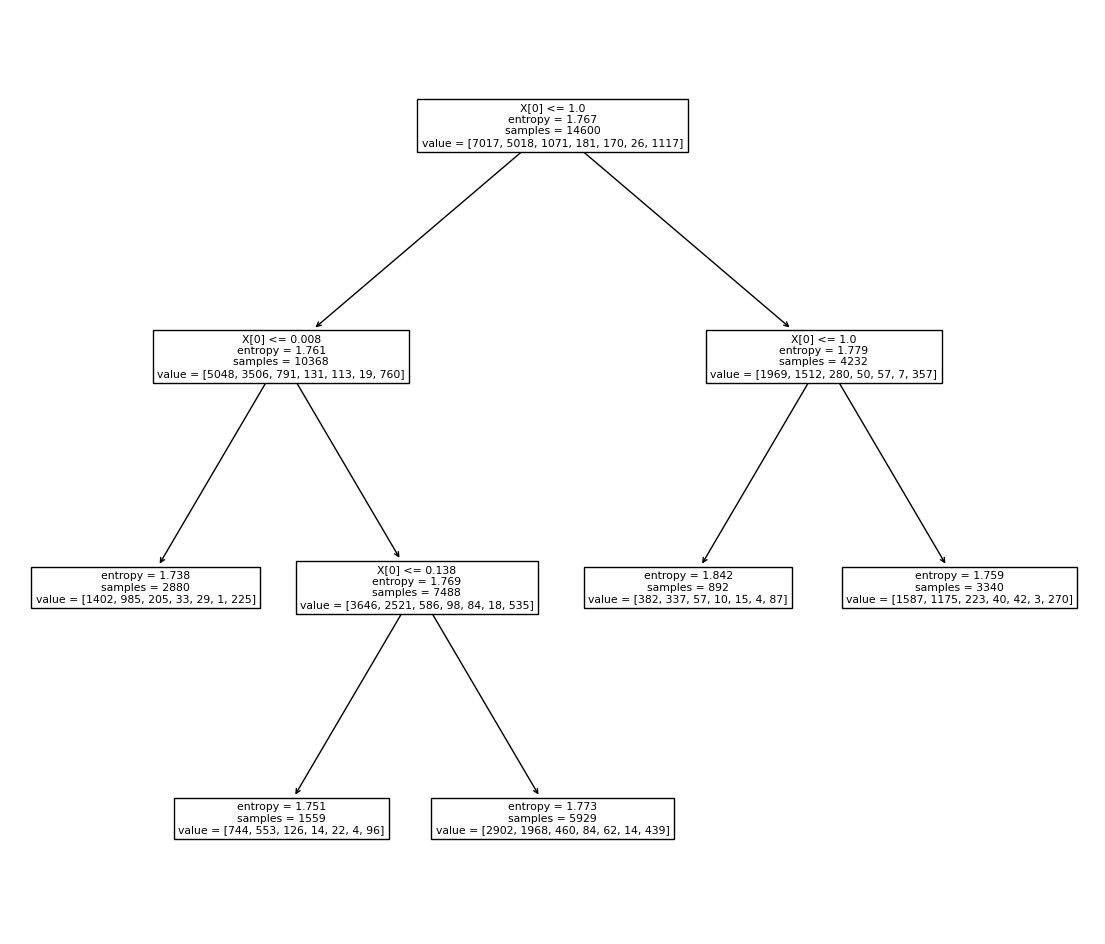

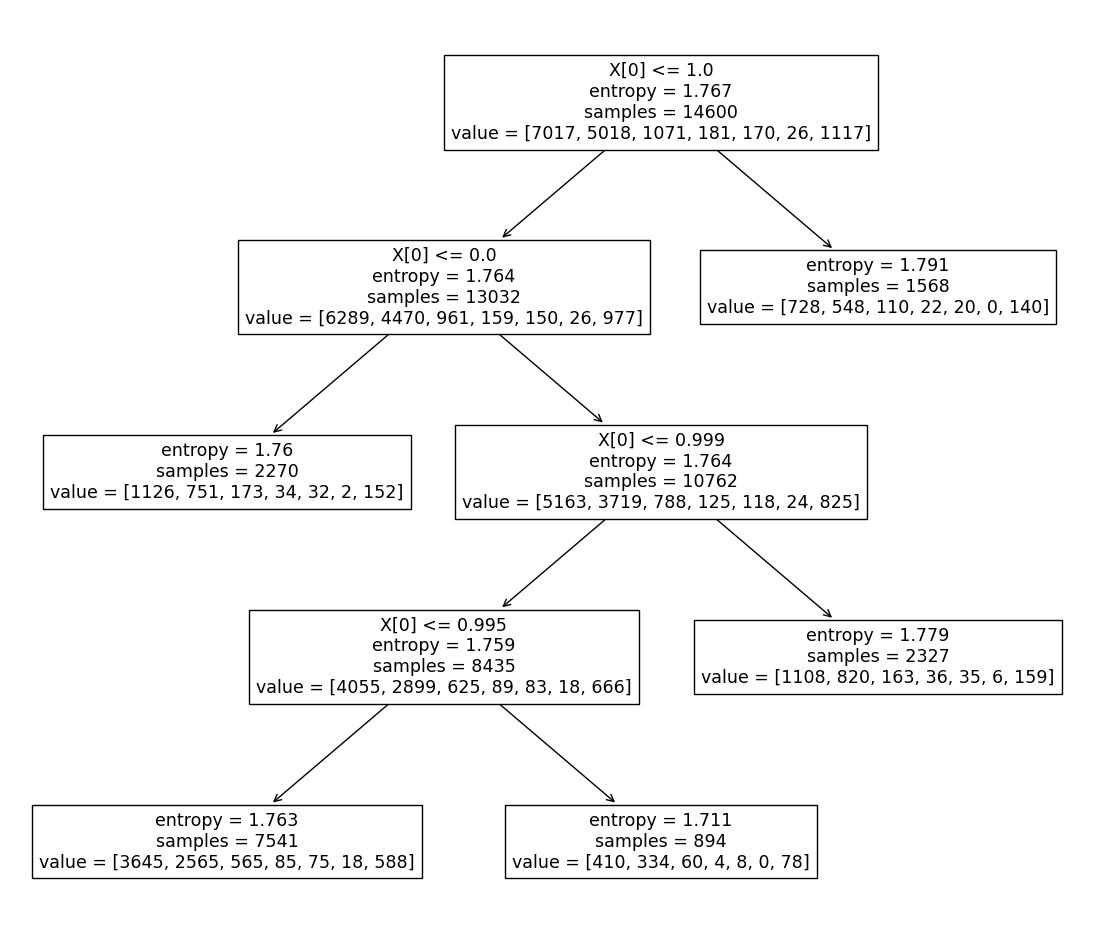

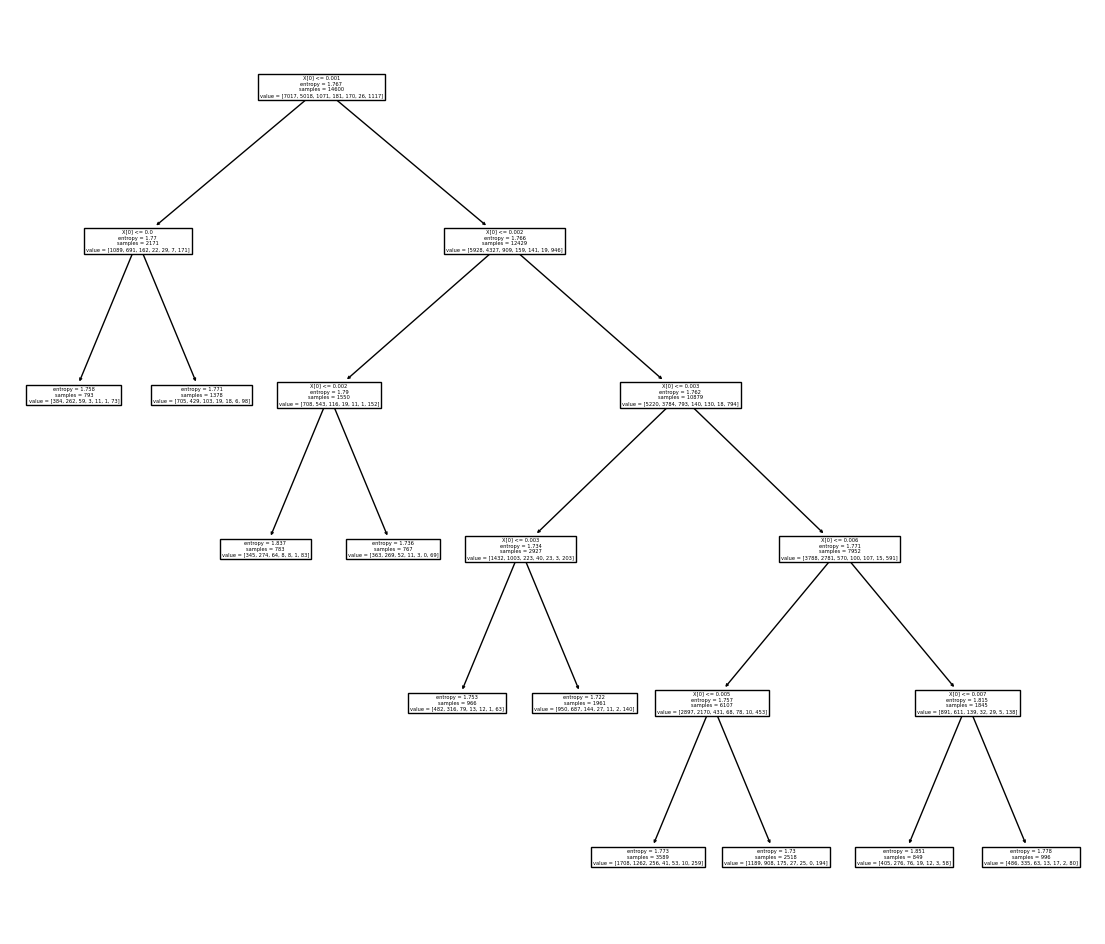

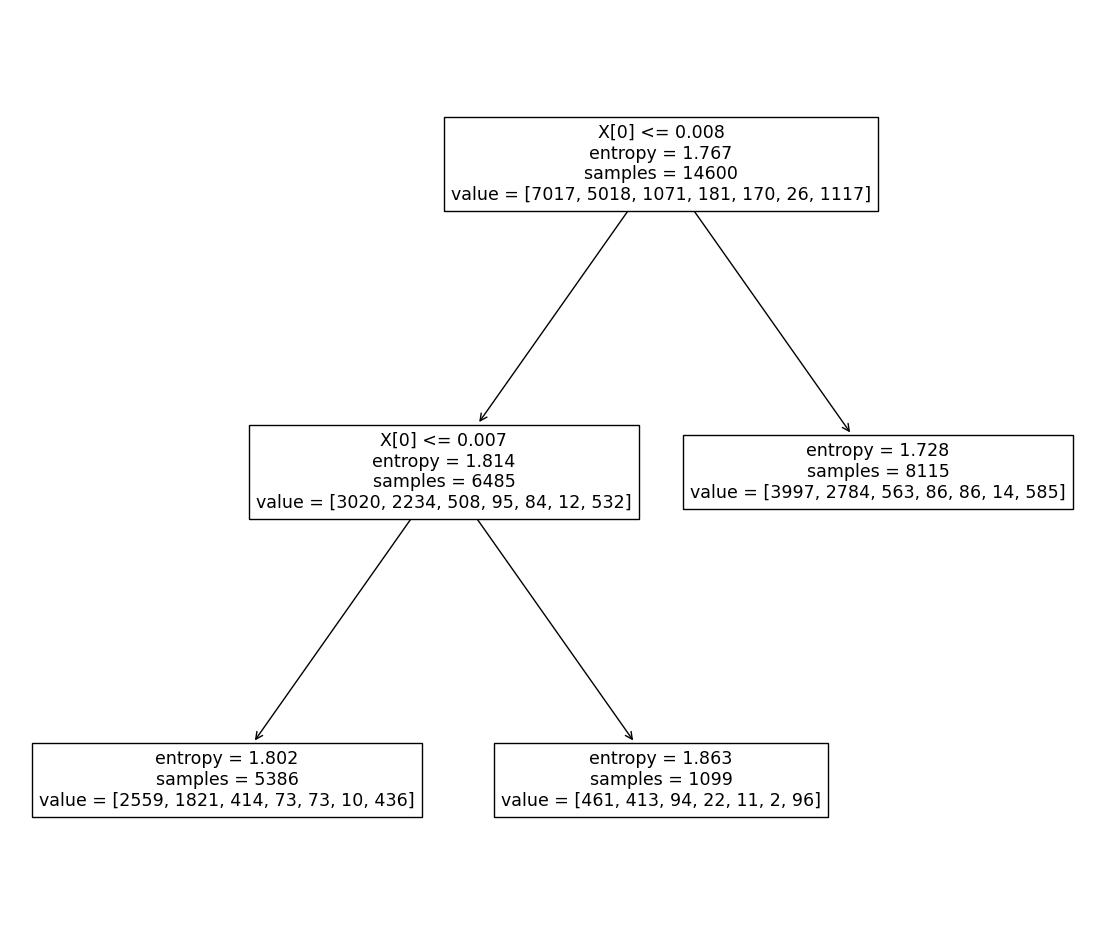

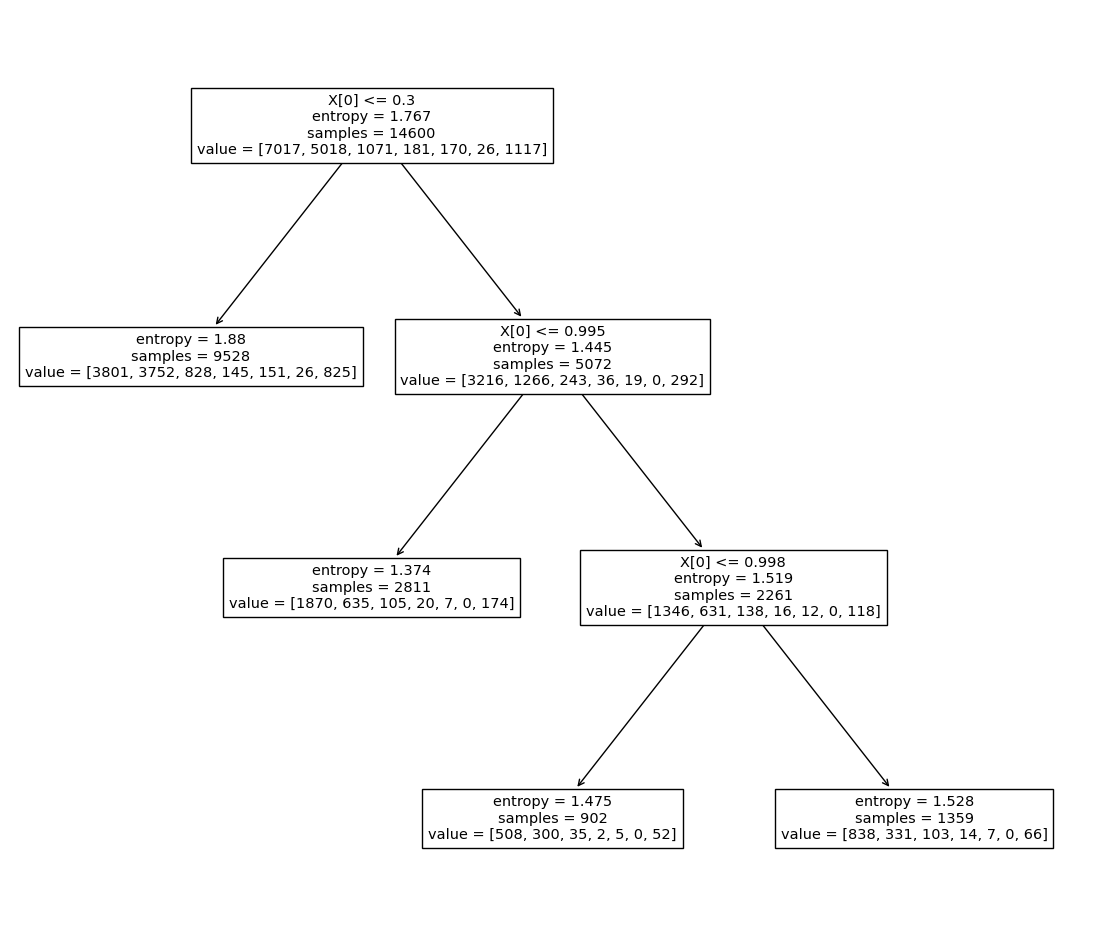

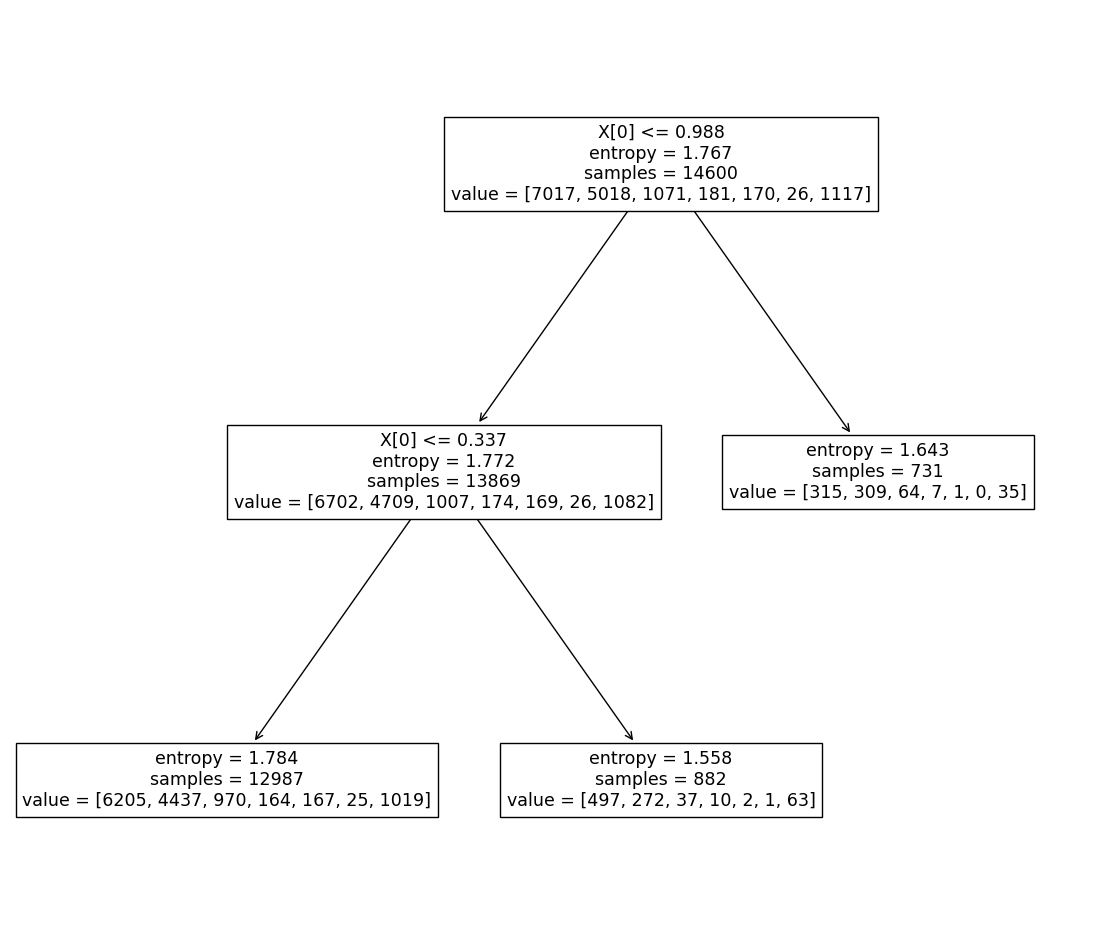

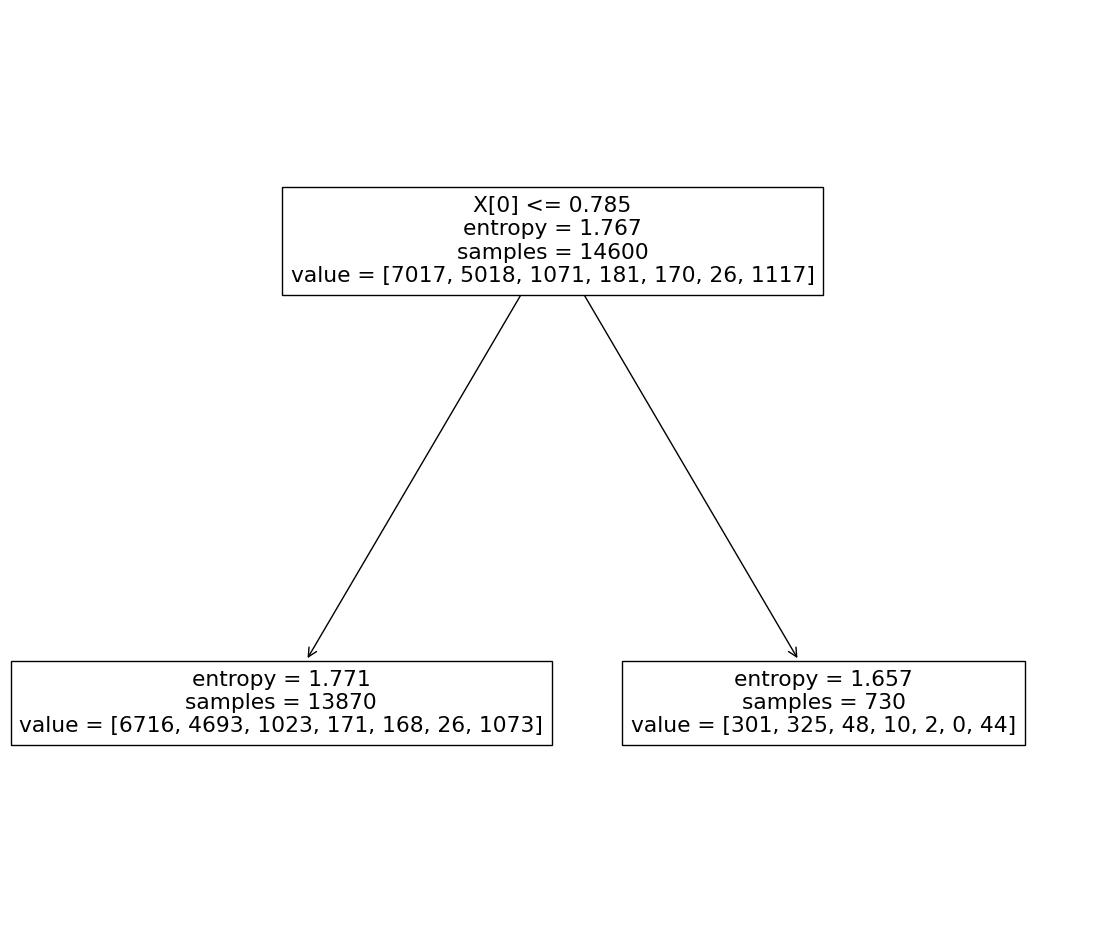

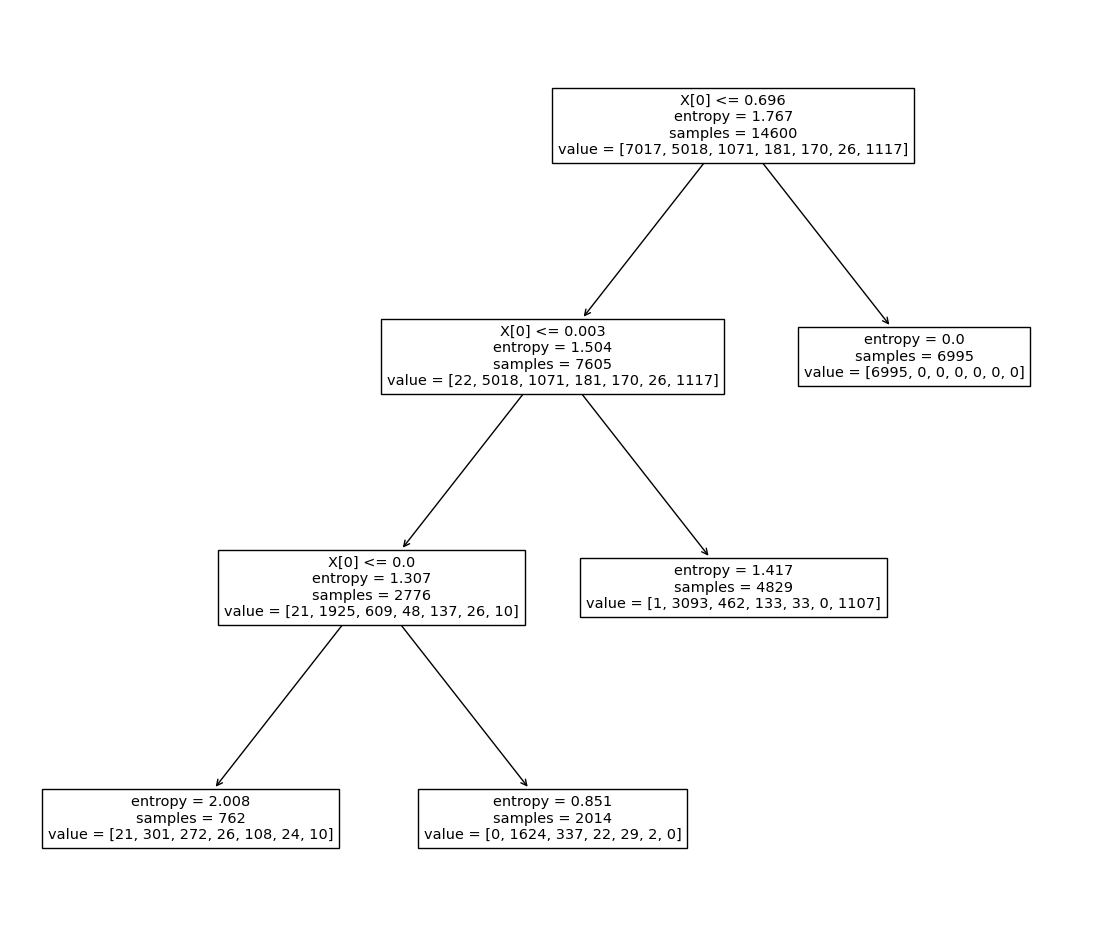

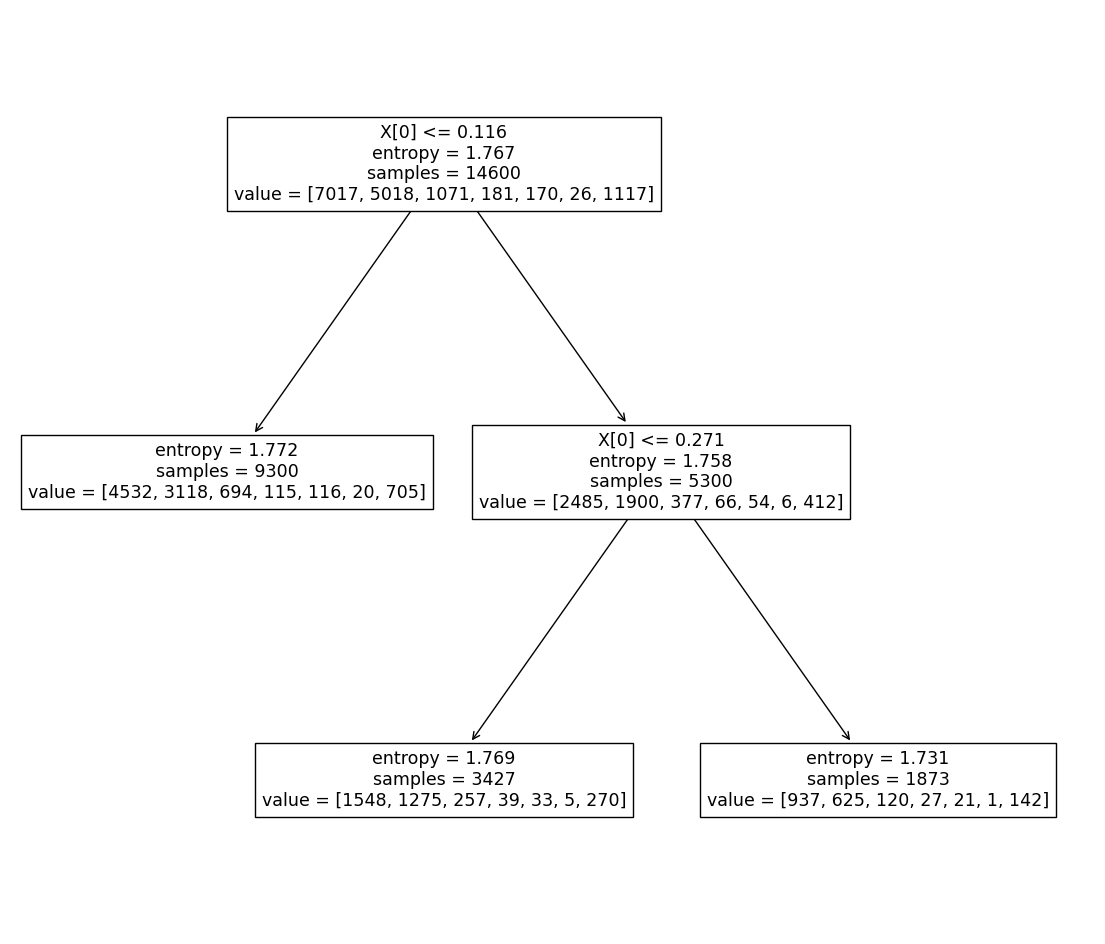

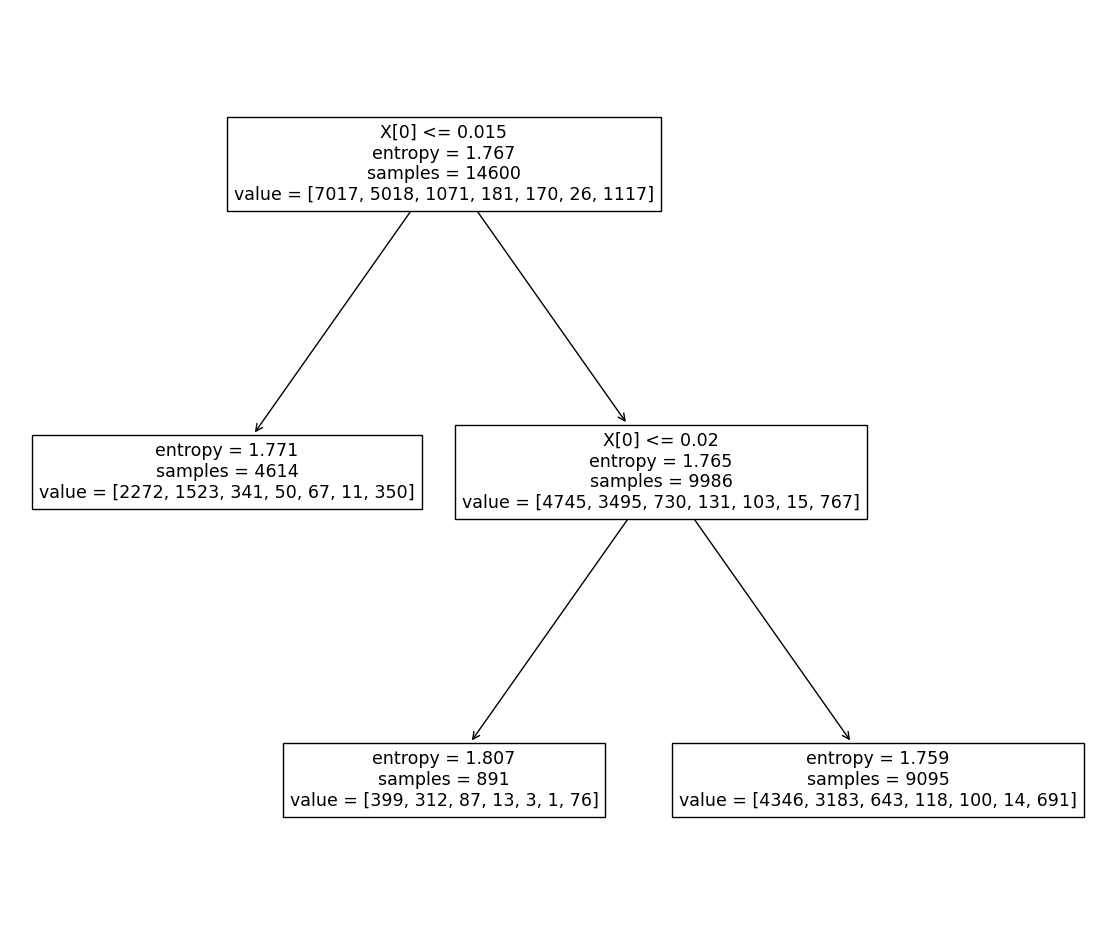

In [15]:
#data_x, data_y = make_classification(n_samples=10000, n_classes=4, n_features=10, n_informative=8, random_state=0)
bin_result1 = decision_tree_binning(X.sentiS.values, X.lookAheadType_.values, max_bin=5)
bin_result2 = decision_tree_binning(X.sentiC.values, X.lookAheadType_.values, max_bin=5)
bin_result3 = decision_tree_binning(X.patientAge.values, X.lookAheadType_.values, max_bin=10)
bin_result4 = decision_tree_binning(X.satisficing.values, X.lookAheadType_.values, max_bin=3)
# bin_result5 = decision_tree_binning(X.askFreq.values, X.lookAheadType_.values, max_bin=10)
# bin_result6 = decision_tree_binning(X.answerFreq.values, X.lookAheadType_.values, max_bin=10)
# bin_result7 = decision_tree_binning(X.checkInFreq.values, X.lookAheadType_.values, max_bin=10)
bin_result8 = decision_tree_binning(X.lookBackLag1.values, X.lookAheadType_.values, max_bin=4)
bin_result9 = decision_tree_binning(X.lookBackLag2.values, X.lookAheadType_.values, max_bin=4)
bin_result10 = decision_tree_binning(X.lookBackLag3.values, X.lookAheadType_.values, max_bin=4)
bin_result11 = decision_tree_binning(X.lookAheadLag.values, X.lookAheadType_.values, max_bin=4)
bin_result12 = decision_tree_binning(X.patientVote.values, X.lookAheadType_.values, max_bin=3)
bin_result13 = decision_tree_binning(X.onlineCons.values, X.lookAheadType_.values, max_bin=3)

bin_value1 = pd.cut(X.sentiS, bin_result1, retbins=True)  # 分箱的结果
bin_value2 = pd.cut(X.sentiC, bin_result2, retbins=True)
bin_value3 = pd.cut(X.patientAge, bin_result3, retbins=True)
bin_value4 = pd.cut(X.satisficing, bin_result4, retbins=True)
# bin_value5 = pd.cut(X.askFreq, bin_result5, retbins=True)
# bin_value6 = pd.cut(X.answerFreq, bin_result6, retbins=True)
# bin_value7 = pd.cut(X.checkInFreq, bin_result7, retbins=True)
bin_value8 = pd.cut(X.lookBackLag1, bin_result8, retbins=True)
bin_value9 = pd.cut(X.lookBackLag2, bin_result9, retbins=True)
bin_value10 = pd.cut(X.lookBackLag3, bin_result10, retbins=True)
bin_value11 = pd.cut(X.lookAheadLag, bin_result11, retbins=True)
bin_value12 = pd.cut(X.patientVote, bin_result12, retbins=True)
bin_value13 = pd.cut(X.onlineCons, bin_result13, retbins=True)

X['sentiS_dtb_group']=X['sentiS'].apply(value2group, args=(bin_value1[1][:-1],))
X['sentiC_dtb_group']=X['sentiC'].apply(value2group, args=(bin_value2[1][:-1],))
X['patientAge_dtb_group']=X['patientAge'].apply(value2group, args=(bin_value3[1][:-1],))
X['satisficing_dtb_group']=X['satisficing'].apply(value2group, args=(bin_value4[1][:-1],))
# X['askFreq_dtb_group']=X['askFreq'].apply(value2group, args=(bin_value5[1][:-1],))
# X['answerFreq_dtb_group']=X['answerFreq'].apply(value2group, args=(bin_value6[1][:-1],))
# X['checkInFreq_dtb_group']=X['checkInFreq'].apply(value2group, args=(bin_value7[1][:-1],))
X['lookBackLag1_dtb_group']=X['lookBackLag1'].apply(value2group, args=(bin_value8[1][:-1],))
X['lookBackLag2_dtb_group']=X['lookBackLag2'].apply(value2group, args=(bin_value9[1][:-1],))
X['lookBackLag3_dtb_group']=X['lookBackLag3'].apply(value2group, args=(bin_value10[1][:-1],))
X['lookAheadLag_dtb_group']=X['lookAheadLag'].apply(value2group, args=(bin_value11[1][:-1],))
X['patientVote_dtb_group']=X['patientVote'].apply(value2group, args=(bin_value12[1][:-1],))
X['onlineCons_dtb_group']=X['onlineCons'].apply(value2group, args=(bin_value13[1][:-1],))

In [17]:
cutoffs1 = chiMerge(X, 'sentiS', 'lookAheadType_', max_groups=5)
cutoffs2 = chiMerge(X, 'sentiC', 'lookAheadType_', max_groups=5)
cutoffs3 = chiMerge(X, 'patientAge', 'lookAheadType_', max_groups=10)
cutoffs4 = chiMerge(X, 'satisficing', 'lookAheadType_', max_groups=3)
# cutoffs5 = chiMerge(X, 'askFreq', 'lookAheadType_', max_groups=10)
# cutoffs6 = chiMerge(X, 'answerFreq', 'lookAheadType_', max_groups=10)
# cutoffs7 = chiMerge(X, 'checkInFreq', 'lookAheadType_', max_groups=10)
cutoffs8 = chiMerge(X, 'lookBackLag1', 'lookAheadType_', max_groups=4)
cutoffs9 = chiMerge(X, 'lookBackLag2', 'lookAheadType_', max_groups=4)
cutoffs10 = chiMerge(X, 'lookBackLag3', 'lookAheadType_', max_groups=4)
cutoffs11 = chiMerge(X, 'lookAheadLag', 'lookAheadType_', max_groups=4)
cutoffs12 = chiMerge(X, 'patientVote', 'lookAheadType_', max_groups=3)
cutoffs13 = chiMerge(X, 'onlineCons', 'lookAheadType_', max_groups=3)

X['sentiS_chi2_group']=X['sentiS'].apply(value2group, args=(cutoffs1,))
X['sentiC_chi2_group']=X['sentiC'].apply(value2group, args=(cutoffs2,))
X['patientAge_chi2_group']=X['patientAge'].apply(value2group, args=(cutoffs3,))
X['satisficing_chi2_group']=X['satisficing'].apply(value2group, args=(cutoffs4,))
# X['askFreq_chi2_group']=X['askFreq'].apply(value2group, args=(cutoffs5,))
# X['answerFreq_chi2_group']=X['answerFreq'].apply(value2group, args=(cutoffs6,))
# X['checkInFreq_chi2_group']=X['checkInFreq'].apply(value2group, args=(cutoffs7,))
X['lookBackLag1_chi2_group']=X['lookBackLag1'].apply(value2group, args=(cutoffs8,))
X['lookBackLag2_chi2_group']=X['lookBackLag2'].apply(value2group, args=(cutoffs9,))
X['lookBackLag3_chi2_group']=X['lookBackLag3'].apply(value2group, args=(cutoffs10,))
X['lookAheadLag_chi2_group']=X['lookAheadLag'].apply(value2group, args=(cutoffs11,))
X['patientVote_chi2_group']=X['patientVote'].apply(value2group, args=(cutoffs12,))
X['onlineCons_chi2_group']=X['onlineCons'].apply(value2group, args=(cutoffs13,))

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [18]:
Xchi = X[['sentiS_chi2_group',
       'sentiC_chi2_group',
       'patientVote_chi2_group', 
       'onlineCons_chi2_group', 
       'patientAge_chi2_group', 
       'satisficing_chi2_group', 
    #    'askFreq_chi2_group', 
    #    'answerFreq_chi2_group',
    #    'checkInFreq_chi2_group',
       'lookBackLag1_chi2_group',
       'lookBackLag2_chi2_group',
       'lookBackLag3_chi2_group',
       'lookAheadLag_chi2_group',
       'patientSex',
       'lookAheadType_',
       'lookBackType1_',
       'lookBackType2_',
       'lookBackType3_',
       'consultingType_']]

Xdtb = X[['sentiS_dtb_group',
       'sentiC_dtb_group',
       'patientVote_dtb_group', 
       'onlineCons_dtb_group', 
       'patientAge_dtb_group', 
       'satisficing_dtb_group', 
    #    'askFreq_dtb_group', 
    #    'answerFreq_dtb_group',
    #    'checkInFreq_dtb_group',
       'lookBackLag1_dtb_group',
       'lookBackLag2_dtb_group',
       'lookBackLag3_dtb_group',
       'lookAheadLag_dtb_group',
       'patientSex',
       'lookAheadType_',
       'lookBackType1_',
       'lookBackType2_',
       'lookBackType3_',
       'consultingType_']]

In [70]:
# Xd_lab_1 = LabelEncoder()
# Xd_lab_2 = LabelEncoder()
# Xd_lab_3 = LabelEncoder()
# Xd_lab_4 = LabelEncoder()
# Xd_lab_5 = LabelEncoder()
# Xd_lab_6 = LabelEncoder()
# Xd_lab_7 = LabelEncoder()
# Xd_lab_8 = LabelEncoder()
# Xd_lab_9 = LabelEncoder()
# Xd_lab_10 = LabelEncoder()
# Xd_lab_11 = LabelEncoder()

# askSenti_dtb_group = pd.Categorical(Xdtb['patientVote_dtb_group'], categories=pd.Categorical(Xdtb['patientVote_dtb_group']).unique())
# checkInSenti_dtb_group = pd.Categorical(Xdtb['onlineCons_dtb_group'], categories=pd.Categorical(Xdtb['onlineCons_dtb_group']).unique())
# patientAge_dtb_group = pd.Categorical(Xdtb['patientAge_dtb_group'], categories=pd.Categorical(Xdtb['patientAge_dtb_group']).unique())
# satisficing_dtb_group = pd.Categorical(Xdtb['satisficing_dtb_group'], categories=pd.Categorical(Xdtb['satisficing_dtb_group']).unique())
# askFreq_dtb_group = pd.Categorical(Xdtb['askFreq_dtb_group'], categories=pd.Categorical(Xdtb['askFreq_dtb_group']).unique())
# answerFreq_dtb_group = pd.Categorical(Xdtb['answerFreq_dtb_group'], categories=pd.Categorical(Xdtb['answerFreq_dtb_group']).unique())
# checkInFreq_dtb_group = pd.Categorical(Xdtb['checkInFreq_dtb_group'], categories=pd.Categorical(Xdtb['checkInFreq_dtb_group']).unique())
# lookBackLag1_dtb_group = pd.Categorical(Xdtb['lookBackLag1_dtb_group'], categories=pd.Categorical(Xdtb['lookBackLag1_dtb_group']).unique())
# lookBackLag2_dtb_group = pd.Categorical(Xdtb['lookBackLag2_dtb_group'], categories=pd.Categorical(Xdtb['lookBackLag2_dtb_group']).unique())
# lookBackLag3_dtb_group = pd.Categorical(Xdtb['lookBackLag3_dtb_group'], categories=pd.Categorical(Xdtb['lookBackLag3_dtb_group']).unique())
# lookAheadLag_dtb_group = pd.Categorical(Xdtb['lookAheadLag_dtb_group'], categories=pd.Categorical(Xdtb['lookAheadLag_dtb_group']).unique())

# askSenti_dtb_group = Xd_lab_1.fit_transform(askSenti_dtb_group)
# checkInSenti_dtb_group = Xd_lab_2.fit_transform(checkInSenti_dtb_group)
# patientAge_dtb_group = Xd_lab_3.fit_transform(patientAge_dtb_group)
# satisficing_dtb_group = Xd_lab_4.fit_transform(satisficing_dtb_group)
# askFreq_dtb_group = Xd_lab_5.fit_transform(askFreq_dtb_group)
# answerFreq_dtb_group = Xd_lab_6.fit_transform(answerFreq_dtb_group)
# checkInFreq_dtb_group = Xd_lab_7.fit_transform(checkInFreq_dtb_group)
# lookBackLag1_dtb_group = Xd_lab_8.fit_transform(lookBackLag1_dtb_group)
# lookBackLag2_dtb_group = Xd_lab_9.fit_transform(lookBackLag2_dtb_group)
# lookBackLag3_dtb_group = Xd_lab_10.fit_transform(lookBackLag3_dtb_group)
# lookAheadLag_dtb_group = Xd_lab_11.fit_transform(lookAheadLag_dtb_group)

X_trial = X.copy()

# X_trial['patientAge'] = pd.Series(patientAge_dtb_group)
X_trial['patientAge'] = Xdtb['patientAge_dtb_group']
X_trial['sentiS'] = Xdtb['sentiS_dtb_group']
X_trial['sentiC'] = Xdtb['sentiC_dtb_group']
X_trial['patientVote'] = Xdtb['patientVote_dtb_group']
X_trial['onlineCons'] = Xdtb['onlineCons_dtb_group']
X_trial['satisficing'] = Xdtb['satisficing_dtb_group']
# X_trial['askFreq'] = Xdtb['askFreq_dtb_group']
# X_trial['answerFreq'] = Xdtb['answerFreq_dtb_group']
# X_trial['checkInFreq'] = Xdtb['checkInFreq_dtb_group']
X_trial['lookBackLag1'] = Xdtb['lookBackLag1_dtb_group']
X_trial['lookBackLag2'] = Xdtb['lookBackLag2_dtb_group']
X_trial['lookBackLag3'] = Xdtb['lookBackLag3_dtb_group']
X_trial['lookAheadLag'] = Xdtb['lookAheadLag_dtb_group']

Xd = X_trial[['sentiS', 'sentiC', 'patientVote', 'onlineCons', 'patientAge', 'satisficing', 'askFreq', 'answerFreq', 'checkInFreq', 'lookBackLag1', 'lookBackLag2', 'lookBackLag3', 'lookAheadLag', 'patientSex', 'lookAheadType_', 'lookBackType1_', 'lookBackType2_', 'lookBackType3_','consultingType_']]

In [71]:
# Xc_lab_1 = LabelEncoder()
# Xc_lab_2 = LabelEncoder()
# Xc_lab_3 = LabelEncoder()
# Xc_lab_4 = LabelEncoder()
# Xc_lab_5 = LabelEncoder()
# Xc_lab_6 = LabelEncoder()
# Xc_lab_7 = LabelEncoder()
# Xc_lab_8 = LabelEncoder()
# Xc_lab_9 = LabelEncoder()
# Xc_lab_10 = LabelEncoder()
# Xc_lab_11 = LabelEncoder()

# askSenti_chi_group = pd.Categorical(Xchi['patientVote_chi2_group'], categories=pd.Categorical(Xchi['patientVote_chi2_group']).unique())
# checkInSenti_chi_group = pd.Categorical(Xchi['onlineCons_chi2_group'], categories=pd.Categorical(Xchi['onlineCons_chi2_group']).unique())
# patientAge_chi_group = pd.Categorical(Xchi['patientAge_chi2_group'], categories=pd.Categorical(Xchi['patientAge_chi2_group']).unique())
# satisficing_chi_group = pd.Categorical(Xchi['satisficing_chi2_group'], categories=pd.Categorical(Xchi['satisficing_chi2_group']).unique())
# askFreq_chi_group = pd.Categorical(Xchi['askFreq_chi2_group'], categories=pd.Categorical(Xchi['askFreq_chi2_group']).unique())
# answerFreq_chi_group = pd.Categorical(Xchi['answerFreq_chi2_group'], categories=pd.Categorical(Xchi['answerFreq_chi2_group']).unique())
# checkInFreq_chi_group = pd.Categorical(Xchi['checkInFreq_chi2_group'], categories=pd.Categorical(Xchi['checkInFreq_chi2_group']).unique())
# lookBackLag1_chi_group = pd.Categorical(Xchi['lookBackLag1_chi2_group'], categories=pd.Categorical(Xchi['lookBackLag1_chi2_group']).unique())
# lookBackLag2_chi_group = pd.Categorical(Xchi['lookBackLag2_chi2_group'], categories=pd.Categorical(Xchi['lookBackLag2_chi2_group']).unique())
# lookBackLag3_chi_group = pd.Categorical(Xchi['lookBackLag3_chi2_group'], categories=pd.Categorical(Xchi['lookBackLag3_chi2_group']).unique())
# lookAheadLag_chi_group = pd.Categorical(Xchi['lookAheadLag_chi2_group'], categories=pd.Categorical(Xchi['lookAheadLag_chi2_group']).unique())

# askSenti_chi_group = Xc_lab_1.fit_transform(askSenti_chi_group)
# checkInSenti_chi_group = Xc_lab_2.fit_transform(checkInSenti_chi_group)
# patientAge_chi_group = Xc_lab_3.fit_transform(patientAge_chi_group)
# satisficing_chi_group = Xc_lab_4.fit_transform(satisficing_chi_group)
# askFreq_chi_group = Xc_lab_5.fit_transform(askFreq_chi_group)
# answerFreq_chi_group = Xc_lab_6.fit_transform(answerFreq_chi_group)
# checkInFreq_chi_group = Xc_lab_7.fit_transform(checkInFreq_chi_group)
# lookBackLag1_chi_group = Xc_lab_8.fit_transform(lookBackLag1_chi_group)
# lookBackLag2_chi_group = Xc_lab_9.fit_transform(lookBackLag2_chi_group)
# lookBackLag3_chi_group = Xc_lab_10.fit_transform(lookBackLag3_chi_group)
# lookAheadLag_chi_group = Xc_lab_11.fit_transform(lookAheadLag_chi_group)

X_trial2 = X.copy()

#X_trial2['onlineCons'] = pd.Series(checkInSenti_chi_group)
X_trial2['sentiS'] = Xchi['sentiS_chi2_group']
X_trial2['sentiC'] = Xchi['sentiC_chi2_group']
X_trial2['patientVote'] = Xchi['patientVote_chi2_group']
X_trial2['onlineCons'] = Xchi['onlineCons_chi2_group']
X_trial2['patientAge'] = Xchi['patientAge_chi2_group']
X_trial2['satisficing'] = Xchi['satisficing_chi2_group']
# X_trial2['askFreq'] = Xchi['askFreq_chi2_group']
# X_trial2['answerFreq'] = Xchi['answerFreq_chi2_group']
# X_trial2['checkInFreq'] = Xchi['checkInFreq_chi2_group']
X_trial2['lookBackLag1'] = Xchi['lookBackLag1_chi2_group']
X_trial2['lookBackLag2'] = Xchi['lookBackLag2_chi2_group']
X_trial2['lookBackLag3'] = Xchi['lookBackLag3_chi2_group']
X_trial2['lookAheadLag'] = Xchi['lookAheadLag_chi2_group']

Xc = X_trial2[['sentiS', 'sentiC', 'patientVote', 'onlineCons', 'patientAge', 'satisficing', 'askFreq', 'answerFreq', 'checkInFreq',  'lookBackLag1', 'lookBackLag2', 'lookBackLag3', 'lookAheadLag', 'patientSex', 'lookAheadType_', 'lookBackType1_', 'lookBackType2_', 'lookBackType3_','consultingType_']]

In [42]:
Xd.to_csv('reframed_dtb_opti.csv')
Xc.to_csv('reframed_chi_opti.csv')

concat weighted advice-based selected senti

In [72]:
Xd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14600 entries, 18 to 383271
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiS           14600 non-null  object 
 1   sentiC           14600 non-null  object 
 2   patientVote      14600 non-null  object 
 3   onlineCons       14600 non-null  object 
 4   patientAge       14600 non-null  object 
 5   satisficing      14600 non-null  object 
 6   askFreq          14600 non-null  float64
 7   answerFreq       14600 non-null  float64
 8   checkInFreq      14600 non-null  float64
 9   lookBackLag1     14600 non-null  object 
 10  lookBackLag2     14600 non-null  object 
 11  lookBackLag3     14600 non-null  object 
 12  lookAheadLag     14600 non-null  object 
 13  patientSex       14600 non-null  int64  
 14  lookAheadType_   14600 non-null  int64  
 15  lookBackType1_   14600 non-null  int64  
 16  lookBackType2_   14600 non-null  int64  
 17  lookBackTy

In [54]:
# X.insert(0, 'index', range(len(X)), allow_duplicates=False)

In [44]:
pd.Categorical(X.lookBackType1_.unique())

[0, 4, 1, 2]
Categories (4, int64): [0, 1, 2, 4]

时间范围筛选

In [18]:
originalData = X.copy()
originalData.insert(0, 'index', range(len(X)), allow_duplicates=False)

# chronic_temp_X1
dateStr1 = dt.strptime('2018-01-01', '%Y-%m-%d')
dateStr2 = dt.strptime('2019-01-01', '%Y-%m-%d')
# chronic_temp_X1
dateStr3 = dt.strptime('2019-01-01', '%Y-%m-%d')
dateStr4 = dt.strptime('2020-01-01', '%Y-%m-%d')
# chronic_temp_X1
dateStr5 = dt.strptime('2020-01-01', '%Y-%m-%d')
dateStr6 = dt.strptime('2021-01-01', '%Y-%m-%d')
# chronic_temp_X1
dateStr7 = dt.strptime('2021-01-01', '%Y-%m-%d')
dateStr8 = dt.strptime('2022-01-01', '%Y-%m-%d')

selected_condition1 = (pd.to_datetime(originalData.lastMod) >= dateStr1)&(pd.to_datetime(originalData.lastMod) <= dateStr2)
selected_condition2 = (pd.to_datetime(originalData.lastMod) >= dateStr3)&(pd.to_datetime(originalData.lastMod) <= dateStr4)
selected_condition3 = (pd.to_datetime(originalData.lastMod) >= dateStr5)&(pd.to_datetime(originalData.lastMod) <= dateStr6)
selected_condition4 = (pd.to_datetime(originalData.lastMod) >= dateStr7)&(pd.to_datetime(originalData.lastMod) <= dateStr8)

# originalData[selected_condition].filter(regex='.Type', axis=1)

# reframedData[selected_condition].filter(regex='.Lag', axis=1)

selected_condition = list()
selected_condition = [selected_condition1, selected_condition2, selected_condition3, selected_condition4]

for i in range(len(selected_condition)):
    selectedData = originalData[selected_condition[i]]
    ind_afterBreakPoint = list(selectedData['index'])
    chronic_temp_X= originalData[[i in ind_afterBreakPoint for i in originalData['index']]]
    chronic_temp_X.to_csv('chronic_2_g6_temp_S_C_X_%s.csv' % i)

trial kmeans 简单聚类

In [735]:
print(X[X.isnull().T.any()])

Empty DataFrame
Columns: [sentiS, sentiC, patientVote, onlineCons, askFreq, answerFreq, checkInFreq, satisficing, lookBackLag1, lookBackLag2, lookBackLag3, lookAheadLag, patientSex, patientAge, consultingType_, lookBackType1_, lookBackType2_, lookBackType3_, lookAheadType_]
Index: []


In [434]:
chronic_temp_X = pd.concat([pd.read_csv('chronic_2_g1_temp_S_C_X_2.csv', index_col=0), pd.read_csv('chronic_2_g1_temp_S_C_X_3.csv', index_col=0)], axis=0)
chronic_temp_X = chronic_temp_X.drop(columns=['index', 'lastMod'])

In [435]:
pd.Categorical(chronic_temp_X['patientAge'], categories=pd.Categorical(chronic_temp_X['patientAge']).unique())

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


[0.0027, 0.0001, 0.0002, 0.0013, 0.0035, ..., 0.000500, 0.003200, 0.003000, 0.006601, 0.000500]
Length: 2964
Categories (82, float64): [0.0001, 0.0002, 0.0003, 0.0004, ..., 0.007901, 0.008001, 0.008101, 0.008801]

In [74]:
X['lookAheadType__dtb_group'].describe()

count    14600.000000
mean         1.042123
std          1.627245
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: lookAheadType_, dtype: float64

In [ ]:
# 转换成二分类

bin_result_e = decision_tree_binning(X.lookAheadType_.values, X.lookAheadType_.values, max_bin=2)
bin_value_e = pd.cut(X.lookAheadType_, bin_result_e, retbins=True)  # 分箱的结果
X['lookAheadType__dtb_group']=X['lookAheadType_'].apply(value2group, args=(bin_value_e[1][:-1],))

cutoffs_e = chiMerge(X, 'lookAheadType_', 'lookAheadType_', max_groups=2)
X['lookAheadType__chi2_group']=X['lookAheadType_'].apply(value2group, args=(cutoffs_e,))

In [41]:
X_trial['lookAheadType_'] = X['lookAheadType__dtb_group']
#X_trial['lookAheadType_'] = X['lookAheadType__chi2_group']
#X_trial['lookAheadType_'] = X['lookAheadType_']

Xd = X_trial[['sentiS', 'sentiC', 'patientVote', 'onlineCons', 'patientAge', 'satisficing', 'askFreq', 'answerFreq', 'checkInFreq', 'lookBackLag1', 'lookBackLag2', 'lookBackLag3', 'lookAheadLag', 'patientSex', 'lookAheadType_', 'lookBackType1_', 'lookBackType2_', 'lookBackType3_','consultingType_']]

In [46]:
Xd = pd.read_csv('reframed_chi_opti.csv', index_col=0)
len(Xd)

44

In [75]:
Xd.describe()

askFreq    answerFreq   checkInFreq    patientSex  lookAheadType_  \
count  14600.000000  14600.000000  14600.000000  14600.000000    14600.000000   
mean       0.331355      0.296263      0.054863      1.085548        1.042123   
std        0.229186      0.149138      0.084089      0.996334        1.627245   
min        0.000000      0.000000      0.000000      0.000000        0.000000   
25%        0.111111      0.166667      0.000000      0.000000        0.000000   
50%        0.333333      0.277778      0.020408      2.000000        1.000000   
75%        0.500000      0.388889      0.081633      2.000000        1.000000   
max        1.000000      1.000000      0.979592      2.000000        6.000000   

       lookBackType1_  lookBackType2_  lookBackType3_  consultingType_  
count    14600.000000    14600.000000    14600.000000     14600.000000  
mean         0.827055        0.277123        0.121370         1.166370  
std          1.428774        0.922534        0.618732         0.418662  
min          0.000000        0.000000        0.000000         0.000000  
25%          0.000000        0.000000        0.000000         1.000000  
50%          0.000000        0.000000        0.000000         1.000000  
75%          1.000000        0.000000        0.000000         1.000000  
max          5.000000        5.000000        5.000000         6.000000

In [77]:
chronic_temp_X = Xd.copy()

le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()
le6 = LabelEncoder()

chronic_temp_X['lookAheadType_'] = le1.fit_transform(chronic_temp_X['lookAheadType_'])

chronic_temp_X['consultingType_'] = le2.fit_transform(chronic_temp_X['consultingType_'])
chronic_temp_X['lookBackType1_'] = le3.fit_transform(chronic_temp_X['lookBackType1_'])
chronic_temp_X['lookBackType2_'] = le4.fit_transform(chronic_temp_X['lookBackType2_'])
chronic_temp_X['lookBackType3_'] = le5.fit_transform(chronic_temp_X['lookBackType3_'])
chronic_temp_X['patientSex'] = le6.fit_transform(chronic_temp_X['patientSex'])

#askFreq, answerFreq, checkInFreq, lookBackLag1, lookBackLag2, lookBackLag3, satisficing, patientVote, onlineCons
Xc_lab_1 = LabelEncoder()
Xc_lab_2 = LabelEncoder()
Xc_lab_3 = LabelEncoder()
Xc_lab_4 = LabelEncoder()
Xc_lab_5 = LabelEncoder()
Xc_lab_6 = LabelEncoder()
Xc_lab_7 = LabelEncoder()
Xc_lab_8 = LabelEncoder()
Xc_lab_9 = LabelEncoder()
Xc_lab_10 = LabelEncoder()
Xc_lab_11 = LabelEncoder()
Xc_lab_12 = LabelEncoder()
Xc_lab_13 = LabelEncoder()

chronic_temp_X['askFreq'] = Xc_lab_1.fit_transform(chronic_temp_X['askFreq'])
chronic_temp_X['answerFreq'] = Xc_lab_2.fit_transform(chronic_temp_X['answerFreq'])
chronic_temp_X['checkInFreq'] = Xc_lab_3.fit_transform(chronic_temp_X['checkInFreq'])
chronic_temp_X['lookBackLag1'] = Xc_lab_4.fit_transform(chronic_temp_X['lookBackLag1'])
chronic_temp_X['lookBackLag2'] = Xc_lab_5.fit_transform(chronic_temp_X['lookBackLag2'])
chronic_temp_X['lookBackLag3'] = Xc_lab_6.fit_transform(chronic_temp_X['lookBackLag3'])
chronic_temp_X['satisficing'] = Xc_lab_7.fit_transform(chronic_temp_X['satisficing'])
chronic_temp_X['patientVote'] = Xc_lab_8.fit_transform(chronic_temp_X['patientVote'])
chronic_temp_X['onlineCons'] = Xc_lab_9.fit_transform(chronic_temp_X['onlineCons'])
chronic_temp_X['lookAheadLag'] = Xc_lab_10.fit_transform(chronic_temp_X['lookAheadLag'])
chronic_temp_X['patientAge'] = Xc_lab_11.fit_transform(chronic_temp_X['patientAge'])

chronic_temp_X['sentiS'] = Xc_lab_12.fit_transform(chronic_temp_X['sentiS'])
chronic_temp_X['sentiC'] = Xc_lab_13.fit_transform(chronic_temp_X['sentiC'])

In [78]:
chronic_temp_X.describe()

sentiS        sentiC   patientVote    onlineCons    patientAge  \
count  14600.000000  14600.000000  14600.000000  14600.000000  14600.000000   
mean       2.017329      1.546712      0.491301      1.306918      5.388562   
std        1.368143      1.233707      0.711712      0.919147      2.648697   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      1.000000      0.000000      0.000000      3.000000   
50%        2.000000      1.000000      0.000000      2.000000      6.000000   
75%        3.000000      3.000000      1.000000      2.000000      7.000000   
max        4.000000      4.000000      2.000000      2.000000      9.000000   

        satisficing       askFreq    answerFreq   checkInFreq  lookBackLag1  \
count  14600.000000  14600.000000  14600.000000  14600.000000  14600.000000   
mean       1.186918      5.964384      5.332740      2.686849      0.595342   
std        0.943318      4.125352      2.684491      4.108004      0.960743   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      2.000000      3.000000      0.000000      0.000000   
50%        2.000000      6.000000      5.000000      1.000000      0.000000   
75%        2.000000      9.000000      7.000000      4.000000      1.000000   
max        2.000000     18.000000     18.000000     32.000000      3.000000   

       lookBackLag2  lookBackLag3  lookAheadLag    patientSex  lookAheadType_  \
count  14600.000000  14600.000000  14600.000000  14600.000000    14600.000000   
mean       0.160548      0.050000      2.236781      1.085548        1.042123   
std        0.484691      0.217952      0.877388      0.996334        1.627245   
min        0.000000      0.000000      0.000000      0.000000        0.000000   
25%        0.000000      0.000000      2.000000      0.000000        0.000000   
50%        0.000000      0.000000      2.000000      2.000000        1.000000   
75%        0.000000      0.000000      3.000000      2.000000        1.000000   
max        2.000000      1.000000      3.000000      2.000000        6.000000   

       lookBackType1_  lookBackType2_  lookBackType3_  consultingType_  
count    14600.000000    14600.000000    14600.000000     14600.000000  
mean         0.827055        0.277123        0.121370         1.166370  
std          1.428774        0.922534        0.618732         0.418662  
min          0.000000        0.000000        0.000000         0.000000  
25%          0.000000        0.000000        0.000000         1.000000  
50%          0.000000        0.000000        0.000000         1.000000  
75%          1.000000        0.000000        0.000000         1.000000  
max          5.000000        5.000000        5.000000         6.000000

In [79]:
chronic_temp_X[['lookAheadType_']].describe()

lookAheadType_
count    14600.000000
mean         1.042123
std          1.627245
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          6.000000

In [736]:
# chronic_temp_X = X.copy()

In [80]:
len(chronic_temp_X)

14600

In [472]:
# snsCondition1 = chronic_temp_X.lookAheadLag.values > 9998
# snsCondition2 = chronic_temp_X.lookBackLag1.values < -9998
# snsCondition3 = chronic_temp_X.lookBackLag2.values < -9998
# snsCondition4 = chronic_temp_X.lookBackLag3.values < -9998
# chronic_temp_X = chronic_temp_X.drop(chronic_temp_X[(snsCondition1)|(snsCondition2)].index)

In [81]:
removeList = list(chronic_temp_X[chronic_temp_X['lookAheadType_'].isin([0])].index)
chronic_temp_X.drop(index = chronic_temp_X[chronic_temp_X.index.isin(removeList)].index, inplace = True)

# chronic_temp_X['consultingType_'] = chronic_temp_X['consultingType_'] + 1

len(removeList)

7017

In [82]:
chronic_temp_X.describe()

sentiS       sentiC  patientVote   onlineCons   patientAge  \
count  7583.000000  7583.000000  7583.000000  7583.000000  7583.000000   
mean      2.032309     1.566794     0.494659     1.317421     5.415667   
std       1.370502     1.238395     0.704915     0.913495     2.641107   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     0.000000     0.000000     3.000000   
50%       2.000000     1.000000     0.000000     2.000000     6.000000   
75%       3.000000     3.000000     1.000000     2.000000     7.000000   
max       4.000000     4.000000     2.000000     2.000000     9.000000   

       satisficing      askFreq   answerFreq  checkInFreq  lookBackLag1  \
count  7583.000000  7583.000000  7583.000000  7583.000000   7583.000000   
mean      1.170249     5.960438     5.330212     2.684162      0.434129   
std       0.941805     4.147570     2.681727     4.096092      0.872878   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%       0.000000     2.000000     3.000000     0.000000      0.000000   
50%       2.000000     6.000000     5.000000     1.000000      0.000000   
75%       2.000000     9.000000     7.000000     4.000000      0.000000   
max       2.000000    18.000000    18.000000    32.000000      3.000000   

       lookBackLag2  lookBackLag3  lookAheadLag   patientSex  lookAheadType_  \
count   7583.000000   7583.000000   7583.000000  7583.000000     7583.000000   
mean       0.160491      0.056574      1.538969     1.083344        2.006462   
std        0.494454      0.231042      0.666316     0.996520        1.778587   
min        0.000000      0.000000      0.000000     0.000000        1.000000   
25%        0.000000      0.000000      1.000000     0.000000        1.000000   
50%        0.000000      0.000000      2.000000     2.000000        1.000000   
75%        0.000000      0.000000      2.000000     2.000000        2.000000   
max        2.000000      1.000000      2.000000     2.000000        6.000000   

       lookBackType1_  lookBackType2_  lookBackType3_  consultingType_  
count     7583.000000     7583.000000     7583.000000      7583.000000  
mean         0.582092        0.267704        0.140314         1.167348  
std          1.242686        0.904615        0.665967         0.419870  
min          0.000000        0.000000        0.000000         0.000000  
25%          0.000000        0.000000        0.000000         1.000000  
50%          0.000000        0.000000        0.000000         1.000000  
75%          0.000000        0.000000        0.000000         1.000000  
max          5.000000        5.000000        5.000000         6.000000

In [83]:
chronic_temp_X.lookBackType2_.value_counts()

0    6796
4     322
1     293
2      97
3      60
5      15
Name: lookBackType2_, dtype: int64

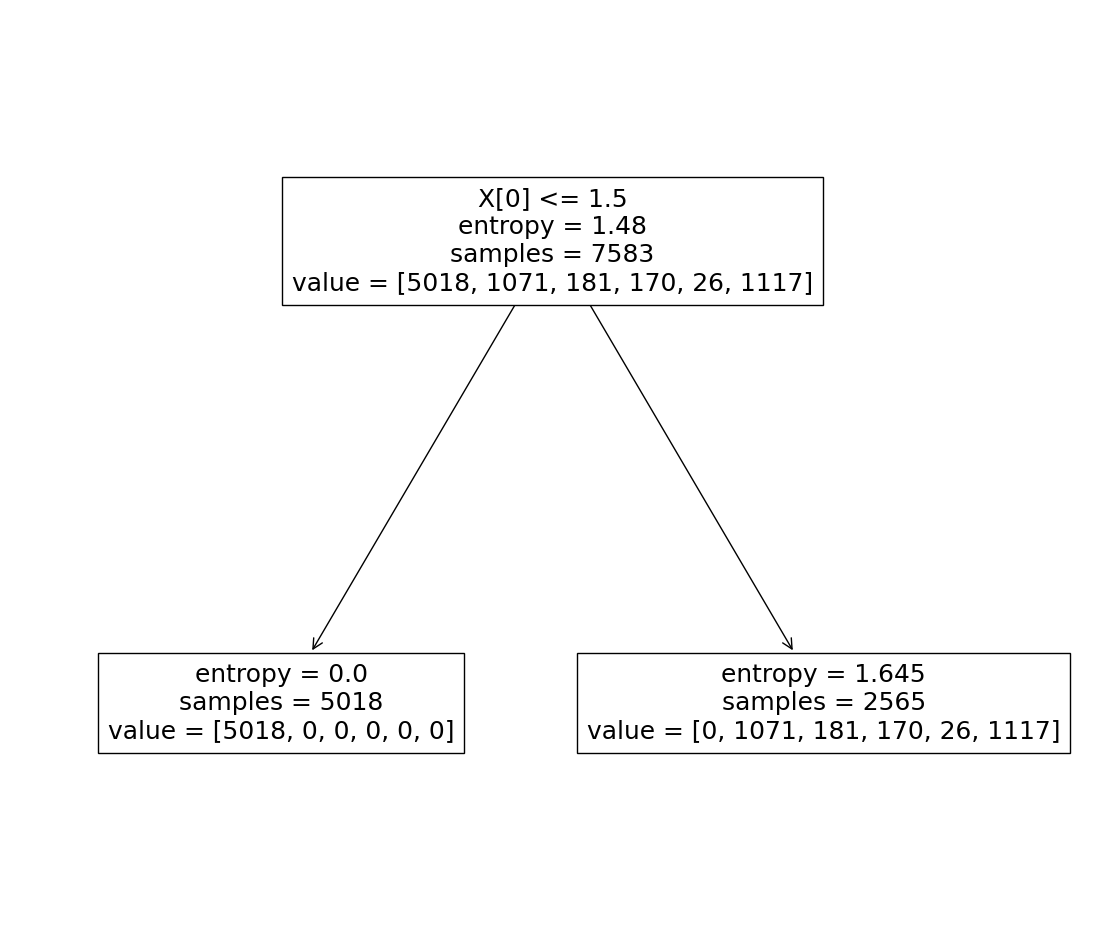

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [28]:
# 转换成二分类

### target lookaheadtype
bin_result_e = decision_tree_binning(chronic_temp_X.lookAheadType_.values, chronic_temp_X.lookAheadType_.values, max_bin=2)
bin_value_e = pd.cut(chronic_temp_X.lookAheadType_, bin_result_e, retbins=True)  # 分箱的结果
chronic_temp_X['lookAheadType__dtb_group']=chronic_temp_X['lookAheadType_'].apply(value2group, args=(bin_value_e[1][:-1],))

cutoffs_e = chiMerge(chronic_temp_X, 'lookAheadType_', 'lookAheadType_', max_groups=2)
chronic_temp_X['lookAheadType__chi2_group']=chronic_temp_X['lookAheadType_'].apply(value2group, args=(cutoffs_e,))

#chronic_temp_X['lookAheadType_'] = chronic_temp_X['lookAheadType__dtb_group']
#chronic_temp_X['lookAheadType_'] = chronic_temp_X['lookAheadType__chi2_group']


###consulting type

# bin_result_e = decision_tree_binning(chronic_temp_X.consultingType_.values, chronic_temp_X.consultingType_.values, max_bin=2)
# bin_value_e = pd.cut(chronic_temp_X.consultingType_, bin_result_e, retbins=True)  # 分箱的结果
# chronic_temp_X['consultingType__dtb_group']=chronic_temp_X['consultingType_'].apply(value2group, args=(bin_value_e[1][:-1],))

# cutoffs_e = chiMerge(chronic_temp_X, 'consultingType_', 'lookAheadType_', max_groups=2)
# chronic_temp_X['consultingType__chi2_group']=chronic_temp_X['consultingType_'].apply(value2group, args=(cutoffs_e,))

# chronic_temp_X['consultingType_'] = chronic_temp_X['consultingType__dtb_group']
#chronic_temp_X['consultingType_'] = chronic_temp_X['consultingType__chi2_group']

le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()

# chronic_temp_X['lookAheadType_'] = le1.fit_transform(chronic_temp_X['lookAheadType_'])
# chronic_temp_X['lookAheadType_'] = chronic_temp_X['lookAheadType_'] + 1
# chronic_temp_X.loc[chronic_temp_X['lookAheadType_'] == 2, 'lookAheadType_'] = 0

# chronic_temp_X['consultingType_'] = le2.fit_transform(chronic_temp_X['consultingType_'])
# chronic_temp_X['lookBackType1_'] = le3.fit_transform(chronic_temp_X['lookBackType1_'])
# chronic_temp_X['lookBackType2_'] = le4.fit_transform(chronic_temp_X['lookBackType2_'])
# chronic_temp_X['lookBackType3_'] = le5.fit_transform(chronic_temp_X['lookBackType3_'])

In [54]:
chronic_temp_X['lookBackType2_'].value_counts()

0    13032
4      634
1      596
2      188
3      106
5       44
Name: lookBackType2_, dtype: int64

In [84]:
chronic_temp_X = chronic_temp_X[['sentiS', 'sentiC', 'patientVote', 'onlineCons',
       'patientAge', 'satisficing', 'askFreq', 'answerFreq', 'checkInFreq',
       'lookBackLag1', 'lookBackLag2', 'lookBackLag3', 'lookAheadLag',
       'patientSex', 'lookAheadType_', 'lookBackType1_', 'lookBackType2_',
       'lookBackType3_', 'consultingType_']]

In [60]:
chronic_temp_X.head()

sentiS  sentiC  patientVote  onlineCons  patientAge  satisficing  \
18        0       1            1           2           5            2   
38        2       1            0           2           2            0   
108       4       4            1           2           8            2   
147       4       1            0           0           9            0   
153       2       2            0           2           4            2   

     askFreq  answerFreq  checkInFreq  lookBackLag1  lookBackLag2  \
18        10           8            3             1             0   
38        12           5            0             0             0   
108        3           6            3             0             0   
147       12           6            1             3             0   
153        0           2            7             0             1   

     lookBackLag3  lookAheadLag  patientSex lookAheadType_  lookBackType1_  \
18              0             3           0         group1               4   
38              0             3           2         group1               0   
108             0             1           0         group2               0   
147             0             3           0         group1               3   
153             0             3           2         group1               0   

     lookBackType2_  lookBackType3_  consultingType_  
18                0               0                1  
38                0               0                1  
108               0               0                1  
147               0               0                1  
153               5               0                2

Training

In [37]:
chronic_temp_X = pd.read_csv('chronicItem_indexed_Xt.csv', index_col=0)

In [766]:
# from sklearn import datasets
# iris = datasets.load_iris()

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

#xx = chronic_temp_X[['askSenti', 'checkInSenti', 'patientAge', 'satisficing', 'askFreq', 'answerFreq', 'checkInFreq', 'lookBackLag1', 'lookBackLag2','lookBackLag3', 'patientSex','lookBackType1_', 'lookBackType2_', 'lookBackType3_','consultingType_']]
#chronic_temp_X.drop(index = chronic_temp_X[chronic_temp_X.index == 34036].index, inplace = True)
#Xt original full
# xx = chronic_temp_X[['patientAge','satisficing','askFreq','answerFreq','checkInFreq','lookBackLag1','lookBackLag2','lookBackLag3','patientSex','lookBackType1_','lookBackType2_','lookBackType3_','consultingType_']]

xx = chronic_temp_X[['answerFreq', 'satisficing', 'checkInFreq', 'patientSex', 'sentiC', 'lookBackLag1', 'lookBackType1_', 'lookBackType2_', 'lookBackType3_', 'consultingType_']]
# + checkInFreq answerFreq patientSex lookBackLag1 satisficing sentiC(balanced)
# - askFreq sentiS(negative balanced)
# ? onlineCons patientVote

yy = chronic_temp_X[['lookAheadType_']]
# target with periods
# yy = chronic_temp_X[['lookAheadLag']]

x_train, x_test, y_train, y_test = train_test_split(xx, yy, train_size = 0.9, random_state = 201, shuffle=True, stratify=yy)

PSM matching

In [86]:
ctx = chronic_temp_X.copy()
ctx.reset_index(drop=True, inplace=True)
ctx = ctx.fillna(0)

PSM_Y = ctx['lookAheadType_'].values
PSM_X = ctx['lookBackType1_'].values
confounders = ctx.drop(columns = ['lookAheadType_','lookBackType1_']).values

In [87]:
from causalinference import CausalModel
model = CausalModel(PSM_Y, PSM_X, confounders)
model.est_via_matching(bias_adj = True)
print(model.estimates)

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


IndexError: index 3860 is out of bounds for axis 0 with size 3169

Result: 1852 out of 7583 samples were correctly labeled.
Accuracy score: 0.24


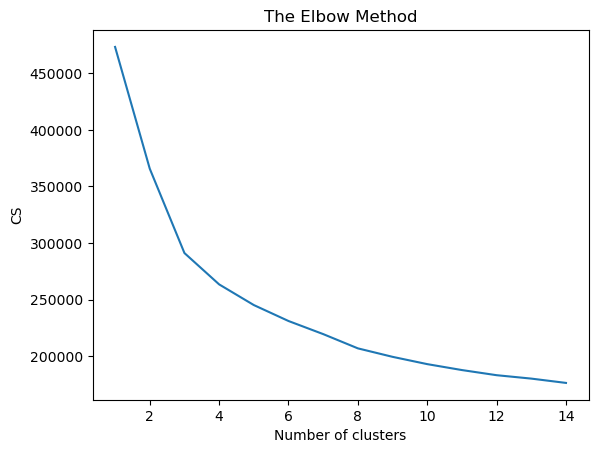

In [88]:
#chronic_temp_X = chronic_temp_X.fillna(0)
kmeans = KMeans(n_clusters = 2, random_state = 200) 
kmeans.fit(xx)

labels = kmeans.labels_

y = chronic_temp_X['lookAheadLag']

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

cs = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 200)
    kmeans.fit(chronic_temp_X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 15), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='lookAheadType_', ylabel='Density'>

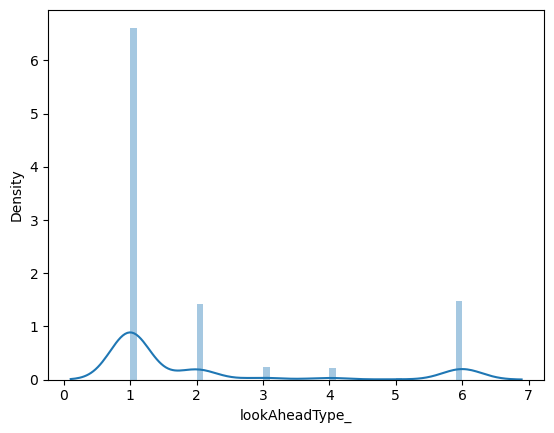

In [89]:
import seaborn as sns
sns.distplot(chronic_temp_X.lookAheadType_)

In [90]:
chronic_temp_X.lookAheadType_.value_counts()

1    5018
6    1117
2    1071
3     181
4     170
5      26
Name: lookAheadType_, dtype: int64

In [356]:
pd.Categorical(xx['lookBackType1_']).unique()

[0, 1, 2, 5, 4, 3]
Categories (6, int64): [0, 1, 2, 3, 4, 5]

SMOTE

In [410]:
from imblearn.over_sampling import SMOTE
#adasyn

# 对训练数据集作平衡处理
over_samples = SMOTE(random_state=1234) 

over_samples_x_train, over_samples_y_train = over_samples.fit_resample(x_train, y_train)

over_samples_x_test, over_samples_y_test = over_samples.fit_resample(x_test, y_test)

# 重抽样前的类别比例
print(y_train.value_counts()/len(y_train))
# 重抽样后的类别比例
print(over_samples_y_train.value_counts()/len(over_samples_y_train))

lookAheadLag
2               0.641584
1               0.281999
0               0.076417
dtype: float64
lookAheadLag
0               0.333333
1               0.333333
2               0.333333
dtype: float64


In [411]:
print(y_test.value_counts()/len(y_test))
print(over_samples_y_test.value_counts()/len(over_samples_y_test))

lookAheadLag
2               0.641261
1               0.282523
0               0.076216
dtype: float64
lookAheadLag
0               0.333333
1               0.333333
2               0.333333
dtype: float64


In [91]:
param_grid = [
        {
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [
             (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
             ]
        }
       ]

mlp = GridSearchCV(MLPClassifier(max_iter=2000), param_grid, cv=3, scoring='roc_auc_ovr')
# mlp = GridSearchCV(MLPClassifier(max_iter=2000), param_grid, cv=3, scoring='roc_auc')

# accuracy, f1, roc_auc

mlp.fit(x_train,y_train)
print("Best parameters set found on development set:")
print(mlp.best_params_)

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/

Best parameters set found on development set:
{'activation': 'tanh', 'hidden_layer_sizes': (14,), 'solver': 'adam'}


In [92]:
# x_train = over_samples_x_train
# y_train = over_samples_y_train

from sklearn.multiclass import OneVsRestClassifier

alpha = np.logspace(-2, 2, 20)  #设置超参数范围
lr = LogisticRegressionCV(Cs = alpha, cv = 3, penalty = 'l2')  #使用L2正则化
lr = LogisticRegression(penalty = 'l2')

dtc = DecisionTreeClassifier()

svc = SVC(probability=True) 

rfc = RandomForestClassifier(n_estimators = 100, criterion = 'gini')

lgbc = OneVsRestClassifier(lgb.LGBMClassifier())
#clf = lgb.LGBMClassifier()

xgbc = OneVsRestClassifier(XGBClassifier())
#xgbc = XGBClassifier()

knc = KNeighborsClassifier()

lr.fit(x_train, y_train)
dtc.fit(x_train,y_train)
svc.fit(x_train,y_train)
lgbc.fit(x_train, y_train)
xgbc.fit(x_train, y_train)
rfc.fit(x_train, y_train)
knc.fit(x_train, y_train)

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when

[12:41:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:41:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [167]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
score_pre = cross_val_score(rmc, xx, yy, cv=10).mean()
score_pre

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

0.4660958904109589

In [168]:
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1
                                ,random_state=90)
    score = cross_val_score(rmc, xx, yy, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# 绘制学习曲线
x = np.arange(1,201,10)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

KeyboardInterrupt: 

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

最大得分：0.9684491078442374 子树数量为：30


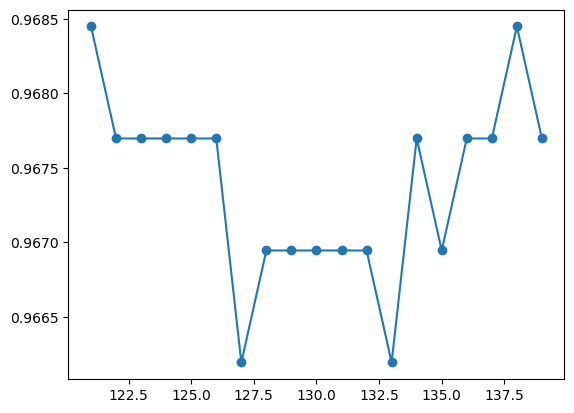

In [152]:
# 在41附近缩小n_estimators的范围为30-49
score_lt = []
for i in range(120,140):
    rfc = RandomForestClassifier(n_estimators=i
                                ,random_state=90)
    score = cross_val_score(rfc, xx, yy, cv=10).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)+120))

# 绘制学习曲线
x = np.arange(120,140)
plt.subplot(111)
plt.plot(x, score_lt,'o-')
plt.show()

In [153]:
# 建立n_estimators为45的随机森林
rfc = RandomForestClassifier(n_estimators=120, random_state=90)

# 用网格搜索调整max_depth
param_grid = {'max_depth':np.arange(1,20)}
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(xx, yy)

best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

{'max_depth': 18} 0.967702839187521


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [65]:
np.shape(xx)

(24, 10)

In [156]:
# 用网格搜索调整max_features
param_grid = {'max_features':np.arange(3,15)}

rfc = RandomForestClassifier(n_estimators=120
                            ,random_state=90
                            ,max_depth=18)
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(xx, yy)
best_param = GS.best_params_
best_score = GS.best_score_
print(best_param, best_score)   

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

{'max_features': 3} 0.967702839187521


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
# plot_importance()

In [93]:
# x_test = over_samples_x_test
# y_test = over_samples_y_test

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
subModel = svc

y_test_b = label_binarize(y = y_test, classes= subModel.classes_)  #装换成类似二进制的编码

#lrm, mlp, tree, svc ...
y_pred=subModel.predict(x_test)
accuracy=accuracy_score(y_pred, y_test)
print('Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

# check for overfitting
# print the scores on training and test set
print('Training set score: {:.4f}'.format(subModel.score(x_train, y_train)))
print('Test set score: {:.4f}'.format(subModel.score(x_test, y_test)))

def get_test_auc(model):
    probs = model.predict_proba(x_test)
    #probs = model.predict(x_test)
    val_auc = roc_auc_score(y_test_b, probs, multi_class='ovr', average='micro')
    #val_auc = roc_auc_score(y_test, probs)
    return val_auc

print("lr_score:",get_test_auc(lr))
print("mlp_score:",get_test_auc(mlp))
print("dtc_score:",get_test_auc(dtc))
print("svc_score:",get_test_auc(svc))
print("lgbc_score:",get_test_auc(lgbc))
print("rfc_score:",get_test_auc(rfc))
print("xgbc_score:",get_test_auc(xgbc))
print("knc_score:",get_test_auc(knc))

Model accuracy score: 0.6614
              precision    recall  f1-score   support

           1       0.66      1.00      0.80       502
           2       0.00      0.00      0.00       107
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00       112

    accuracy                           0.66       759
   macro avg       0.11      0.17      0.13       759
weighted avg       0.44      0.66      0.53       759



/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Training set score: 0.6618
Test set score: 0.6614
lr_score: 0.8828570982205628
mlp_score: 0.8930087956381134
dtc_score: 0.7295021012670092
svc_score: 0.8872106526686352
lgbc_score: 0.8896502401572001
rfc_score: 0.855540974272715
xgbc_score: 0.8873915300105366
knc_score: 0.8236706296510387


PR curve

In [67]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

subModel = svc
y_score = subModel.predict(x_test)

average_precision = average_precision_score(y_test, y_score)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(subModel, x_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


ValueError: Expected 'estimator' to be a binary classifier, but got SVC fit on multiclass (3 classes) data

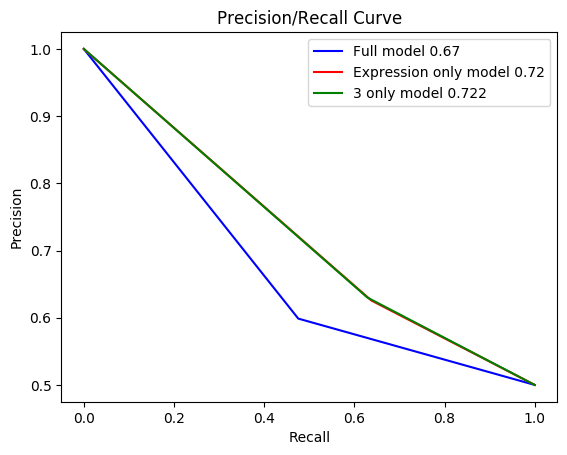

In [539]:
subModel = rfc
subModel2 = lgbc
subModel3 = xgbc

from sklearn import metrics

from sklearn.metrics import precision_recall_curve,average_precision_score
y_pred_proba = subModel.predict(x_test)
y_pred_proba2 = subModel2.predict(x_test)
y_pred_proba3 = subModel3.predict(x_test)
# precision, recall值的计算
precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test,y_pred_proba2)
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test,y_pred_proba3)
# average_precision值的计算
pr_auc = metrics.auc(recall, precision)
pr_auc_2 = metrics.auc(recall_2, precision_2)
pr_auc_3 = metrics.auc(recall_3, precision_3)

plt.plot(recall,precision, color = 'blue')
plt.plot(recall_2,precision_2, color = 'red')
plt.plot(recall_3,precision_3, color = 'green')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper right", labels = ['Full model {}'.format(round(pr_auc, 2)), 'Expression only model {}'.format(round(pr_auc_2, 2)), '3 only model {}'.format(round(pr_auc_3, 3))])
plt.show()

0.5469351732991015


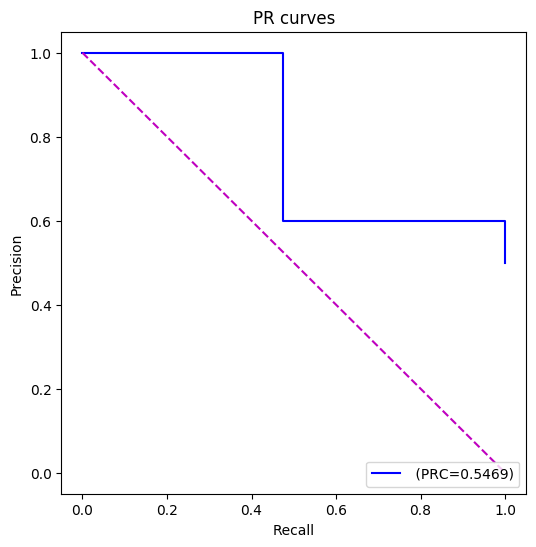

In [540]:
subModel = rfc

from sklearn.metrics import precision_recall_curve,average_precision_score
# precision, recall值的计算
precision, recall, thresholds = precision_recall_curve(y_test,subModel.predict(x_test))
# average_precision值的计算
#pr_auc = auc(recall, precision)
PRC = average_precision_score(y_test,subModel.predict(x_test))
print(PRC)
# PRC曲线绘制
plt.figure(figsize=(6,6))
plt.title('PR curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.step(recall, precision, color='b', label=' (PRC={:.4f})'.format(PRC))
plt.plot([0, 1], [1, 0], color='m', linestyle='--')
plt.legend(loc='lower right')
# 保存图片(常用格式如下)
plt.savefig('PR curves.jpg',dpi=300) 
plt.savefig('PR curves.pdf',dpi=300) 
plt.savefig('PR curves.png',dpi=300) 
plt.show()

Multi-label average PR curve

In [95]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

subModel = svc

yyy_one_hot = label_binarize(y_test, classes=subModel.classes_)
n_classes = yyy_one_hot.shape[1]
y_score = subModel.predict_proba(x_test)

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(yyy_one_hot[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(yyy_one_hot[:, i], y_score[:, i])

# 一个"微观平均": 共同量化所有课程的分数
precision["micro"], recall["micro"], _ = precision_recall_curve(yyy_one_hot.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(yyy_one_hot, y_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.63


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.63')

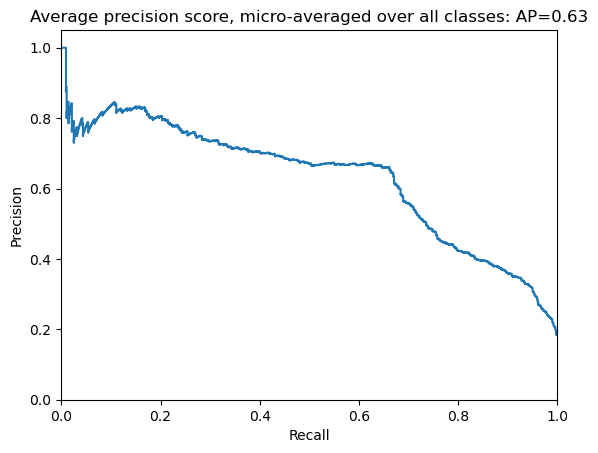

In [96]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

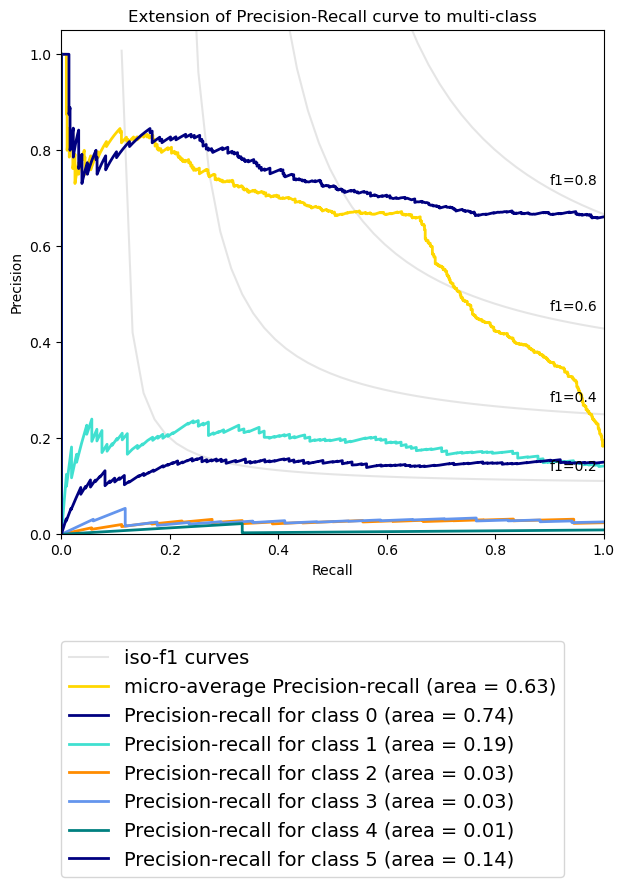

In [97]:
from itertools import cycle
# 设置绘图细节
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.68), prop=dict(size=14))


plt.show()

boruta

In [98]:
from boruta import BorutaPy #Boruta模块
#from __future__ import print_function

modelFC = RandomForestClassifier(n_jobs=-1, max_depth=5)
boruta_model = BorutaPy(estimator=modelFC, n_estimators='auto', 
                        max_iter=100  # number of trials to perform
)
boruta_model.fit(np.array(xx), np.array(yy))
    # 输出结果
boruta_model.support_    #筛选后的特征，False代表滤除掉此特征
boruta_model.ranking_   #1为选定的特征，2为暂定特征
green_area = xx.columns[boruta_model.support_].to_list()
blue_area = xx.columns[boruta_model.support_weak_].to_list() 
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

# boruta选择的特征个数
print ('\n Number of selected features:')
print (boruta_model.n_features_)

# top特征（也就是被选择的特征）
# feature_df = pd.DataFrame(train.drop(['id','target'], axis=1).columns.tolist(), columns=['features'])
# feature_df['rank']=boruta_selector.ranking_
# feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
# print ('\n Top %d features:' % boruta_selector.n_features_)
# print (feature_df.head(boruta_selector.n_features_))
# feature_df.to_csv('boruta-feature-ranking.csv', index=False)

# 原始特征的排序
print ('\n Feature ranking:')
print (boruta_model.ranking_)

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was

features in the green area: ['lookBackType1_', 'lookBackType2_', 'lookBackType3_']
features in the blue area: ['answerFreq', 'lookBackLag1']

 Number of selected features:
3

 Feature ranking:
[2 5 3 7 4 2 1 1 1 6]


In [99]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_pred, y_test, average='weighted')
print('precision Score: %.2f%%' % (precision*100.0))

recall = recall_score(y_pred, y_test, average='weighted')
print('recall Score: %.2f%%' % (recall*100.0))

precision Score: 100.00%
recall Score: 66.14%


/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
from sklearn.ensemble import StackingClassifier 
from sklearn.linear_model import LogisticRegression 
 
stacking = StackingClassifier(
    estimators=[('mlp',mlp),('lr',lr),('dtc',dtc),('svc',svc),('lgbc',lgbc),('rfc',rfc),('xgbc',xgbc),('knc',knc)],
    final_estimator=LogisticRegression())
 
stacking.fit(x_train,y_train)
 
print("stacking_score:",get_test_auc(stacking))

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt

[13:32:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:32:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:32:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Converg

[15:14:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:14:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


stacking_score: 0.8918089643643863


super parameter： [1 2 3 4 5 6]
call the function micro avg auc： 0.8918089643643863
handly calculated micro auc： 0.8918089643643863


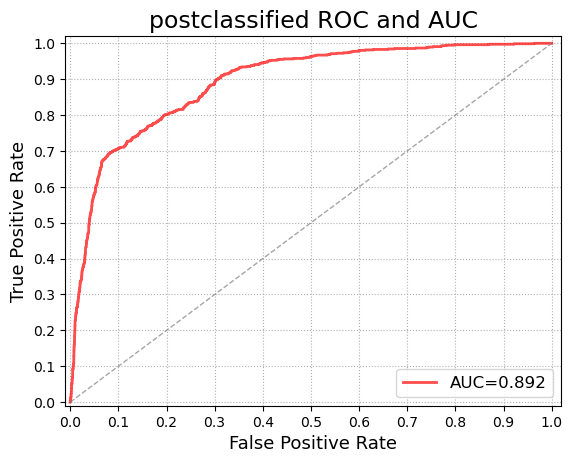

In [101]:
from sklearn.metrics import auc, roc_curve
#model name: lr dtc svc rfc lgbc xgbc stacking

model = stacking
print('super parameter：', model.classes_)
# 计算属于各个类别的概率，返回值的shape = [n_samples, n_classes]
y_score = model.predict_proba(x_test)
#y_score = model.predict(x_test)

# 1、调用函数计算micro类型的AUC
y_one_hot = label_binarize(y = y_test, classes= model.classes_)  #装换成类似二进制的编码
#print('call the function macro avg auc：', roc_auc_score(y_one_hot, y_score, average='macro'))
#print('call the function weighted avg auc：', roc_auc_score(y_one_hot, y_score, average='weighted'))
print('call the function micro avg auc：', roc_auc_score(y_one_hot, y_score, average='micro'))
# print('call the function macro avg auc：', roc_auc_score(y_test, y_score))

# 2、手动计算micro类型的AUC
#首先将矩阵y_one_hot和y_score展开，然后计算假正例率FPR和真正例率TPR
# fpr, tpr, thresholds = roc_curve(y_test, y_score)
fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(), y_score.ravel())
auc = auc(fpr, tpr)
print('handly calculated micro auc：', auc)
#绘图
# mpl.rcParams['font.sans-serif'] = u'SimHei'
# mpl.rcParams['axes.unicode_minus'] = False
#FPR就是横坐标,TPR就是纵坐标
plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % auc)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(visible=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'postclassified ROC and AUC', fontsize=17)
plt.show()

In [103]:
import copy
import sklearn.model_selection as ms
# 五，获取CV预测结果

# 为了充分利用训练数据集，采用类似stacking的方式，用5折CV的方式获取各个模型在训练集的预测结果

def get_cv_preds(model,x_train,y_train):
    
    cv = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    cv_preds = np.zeros((len(y_train), 6))
    
    for idx, (train_idx, valid_idx) in enumerate(cv.split(x_train, y_train)):
        xtrain_i, xvalid_i = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        ytrain_i, yvalid_i = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model_idx = copy.deepcopy(model)
        model_idx.fit(xtrain_i, ytrain_i)
        probs_valid_idx = model_idx.predict_proba(xvalid_i)
        cv_preds[valid_idx] = probs_valid_idx
    return cv_preds

preds_cv = {name: get_cv_preds(eval(name),x_train,y_train) for name in ['mlp', 'lr','dtc','svc','lgbc','rfc', 'xgbc', 'knc']}


/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[22:10:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:10:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:10:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:10:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:10:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:10:31] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_52i0zqsusg/croot/xgboost-split_1675119655573/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set

/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/luoqk/opt/anaconda3/envs/shap-e/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A

In [ ]:
# from sklearn import preprocessing
# y_enc = preprocessing.OneHotEncoder()
# yyy = y_enc.fit_transform(np.array(y_train).reshape(-1, 1))

In [104]:
import optuna 
optuna.logging.set_verbosity(optuna.logging.WARNING)
 
model_list = ['mlp','lr','dtc','svc','lgbc','rfc','xgbc', 'knc']
#y_train_one_hot = label_binarize(y = y_train, classes= model.classes_)  #装换成类似二进制的编码
y_train_one_hot = label_binarize(y = y_train, classes= model.classes_)  #装换成类似二进制的编码

def objective(trial):
    weights = {name:trial.suggest_int(name, 1, 100) for name in model_list}
    probs = sum([weights[name]*preds_cv[name] for name in model_list])/sum(
        [weights[name] for name in model_list])
    
    cv_auc = roc_auc_score(y_train_one_hot,probs, multi_class='ovr', average='micro')
    trial.report(cv_auc, 0)
    return cv_auc
 
storage_name = "sqlite:///optuna.db"
study = optuna.create_study(
    direction="maximize",
    study_name="optuna_09024_36", storage=storage_name,load_if_exists=False
)
study.optimize(objective, n_trials=900, timeout=600)
 
best_params = study.best_params
best_value = study.best_value
print("\n\nbest_value = "+str(best_value))
print("best_params:")
print(best_params)



best_value = 0.8924059187351997
best_params:
{'mlp': 65, 'lr': 97, 'dtc': 6, 'svc': 86, 'lgbc': 61, 'rfc': 3, 'xgbc': 3, 'knc': 1}


In [105]:
# 七， optuna权重融合效果
model = rfc
y_one_hot = label_binarize(y = y_test, classes= model.classes_)  #装换成类似二进制的编码

preds_test = {name:(eval(name)).predict_proba(x_test) for name in model_list}
def test_score(weights):
    probs = sum([weights[name]*preds_test[name] for name in model_list])/sum(
        [weights[name] for name in model_list])
    test_auc = roc_auc_score(y_one_hot,probs,multi_class='ovr',average='micro')
    return test_auc
print('optuna_ensemble_score:',
      test_score(best_params))

optuna_ensemble_score: 0.8946085706697496


shap explanation

In [427]:
import shap

shap.initjs()

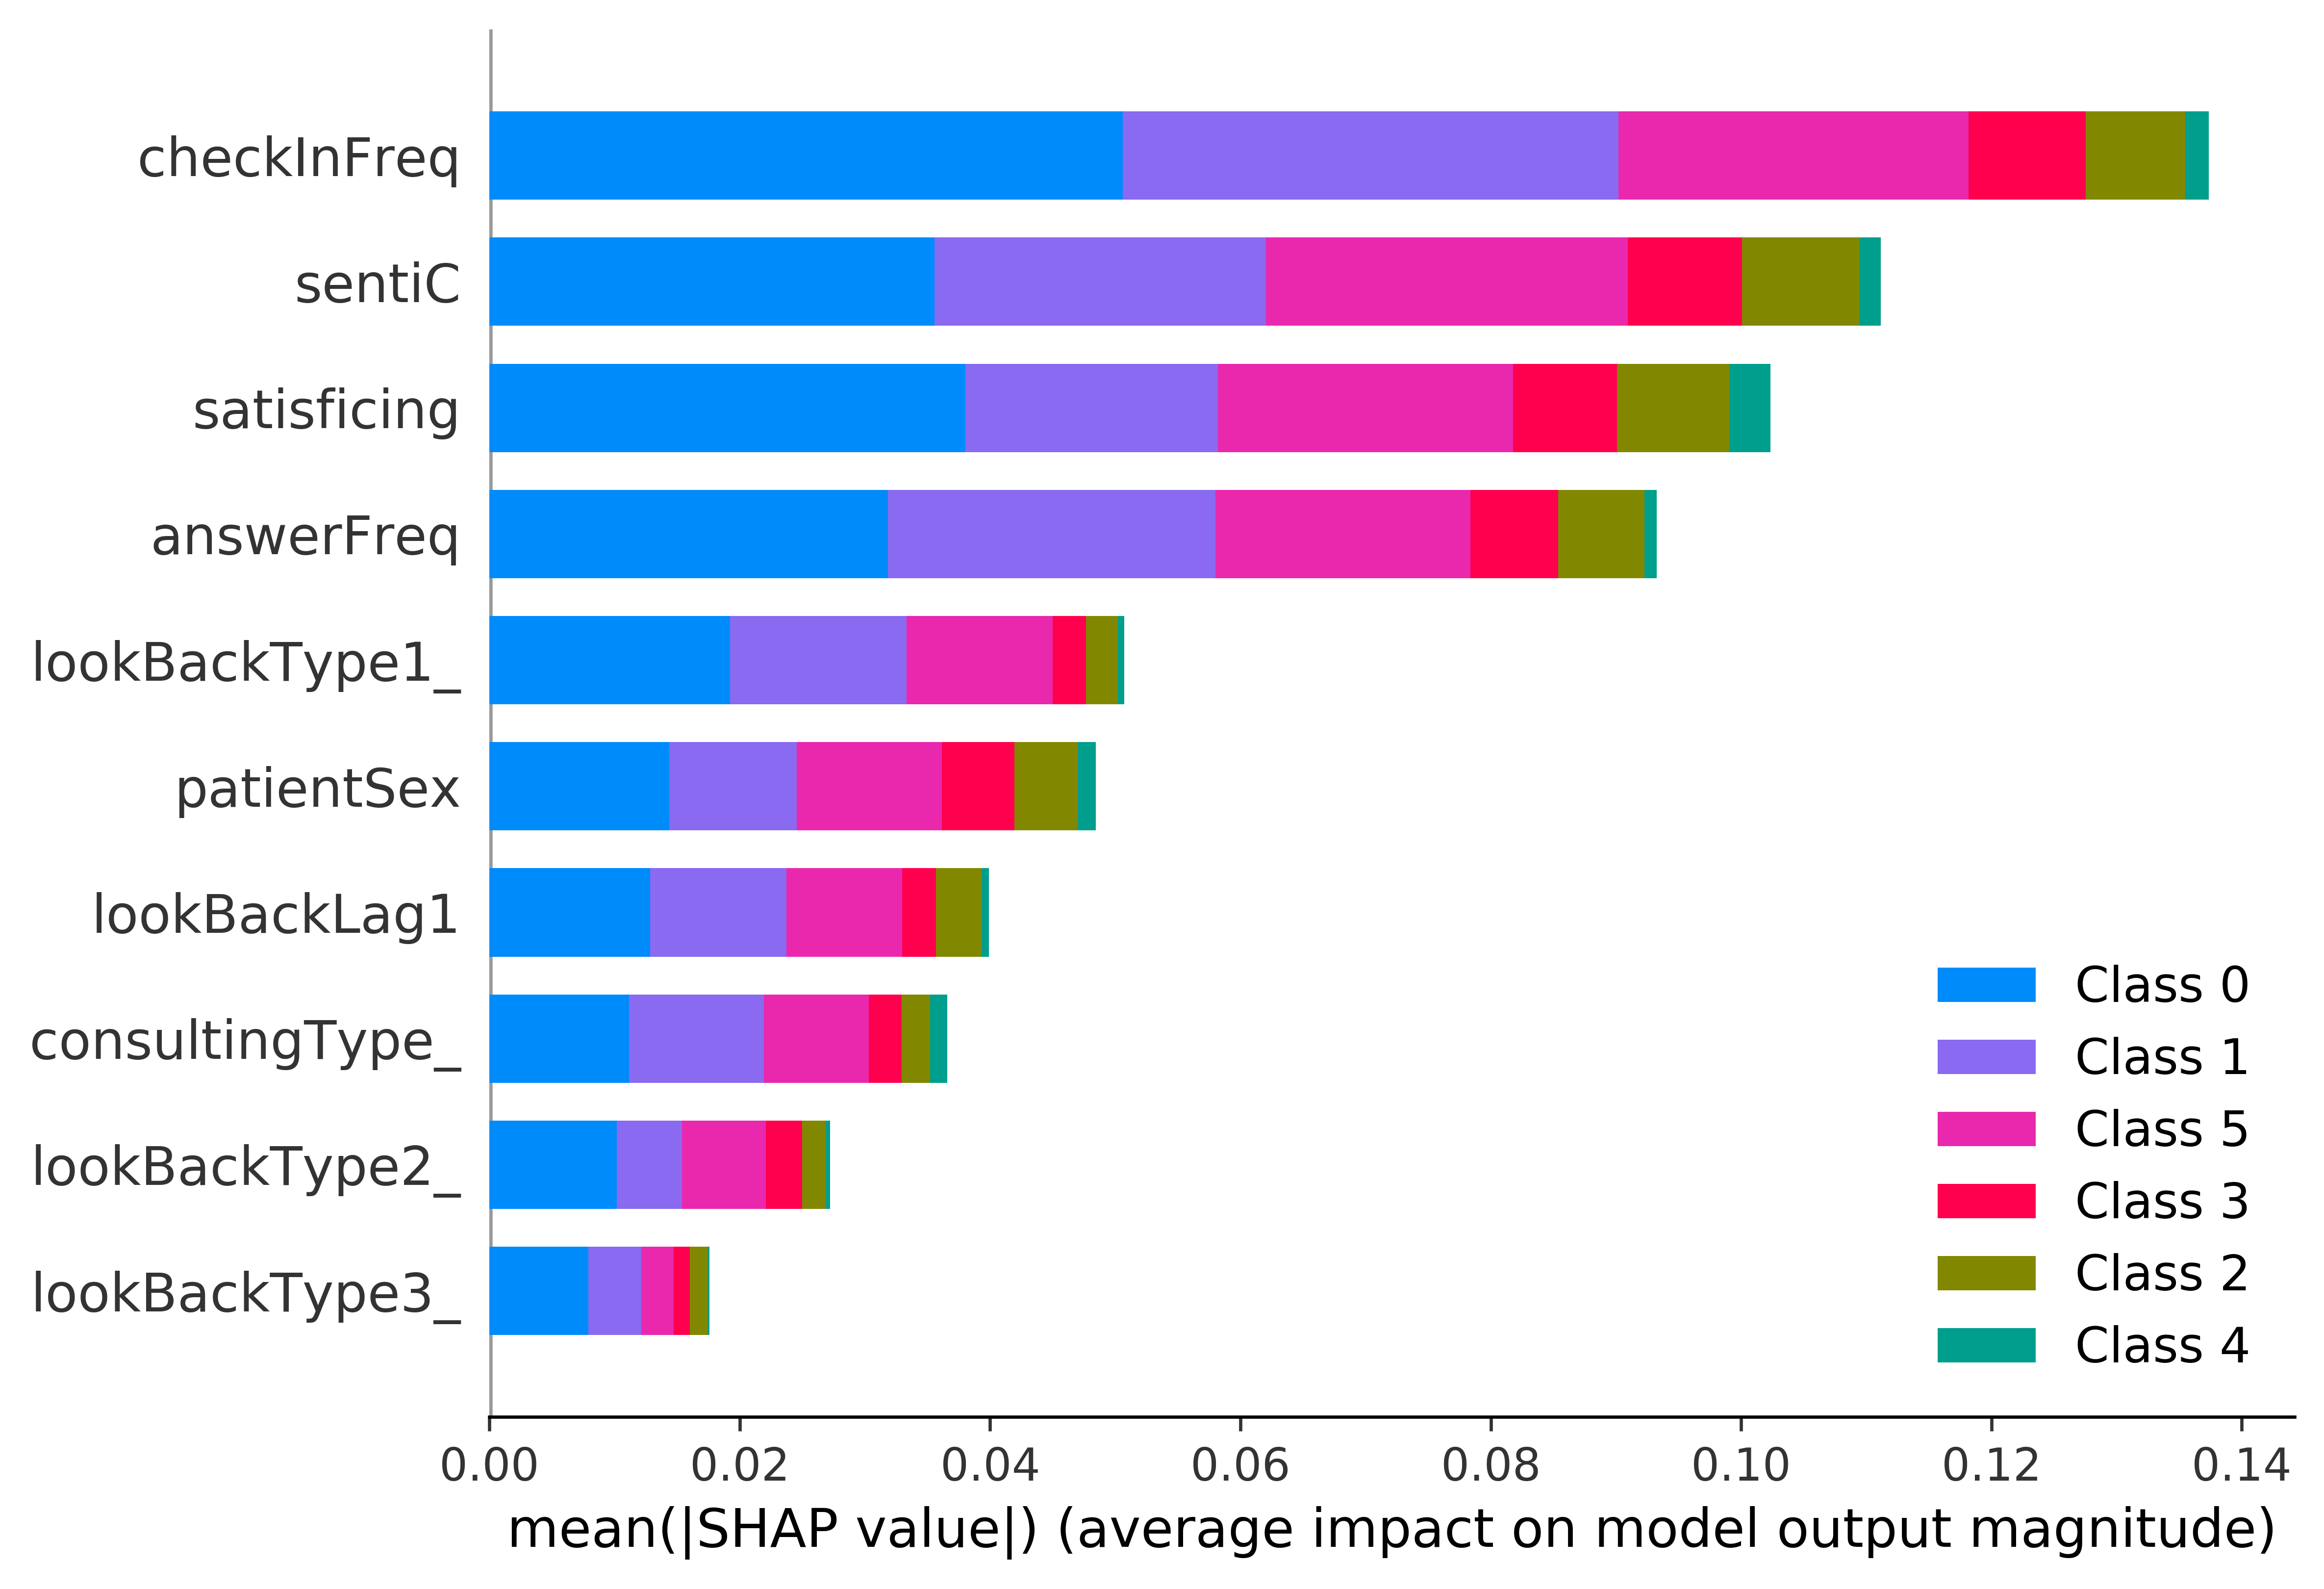

In [466]:
fig = plt.figure(figsize=(3, 8), dpi=600)
shap_values = shap.TreeExplainer(rfc).shap_values(x_test)
shap.summary_plot(shap_values, x_test)
#shap.plots.beeswarm(shap_values)
#shap.plots.bar(shap_values, max_display=10) # default is max_display=12
plt.show()

In [ ]:
shap_values = shap.KernelExplainer(mlp).shap_values(x_test)
shap.summary_plot(shap_values, x_test)

In [ ]:
shap_values = shap.DeepExplainer(mlp).shap_values(x_test)
shap.summary_plot(shap_values, x_test)

In [144]:
# np.shape(np.array(shap_values).T[0])

(761, 7)

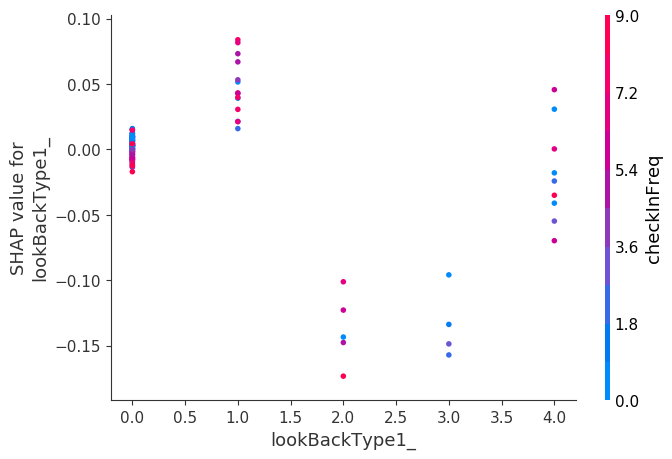

In [467]:
#shap.dependence_plot('checkInFreq', np.array(shap_values[0]), x_test)
shap.dependence_plot('lookBackType1_', features = x_test, shap_values = np.array(shap_values)[0])

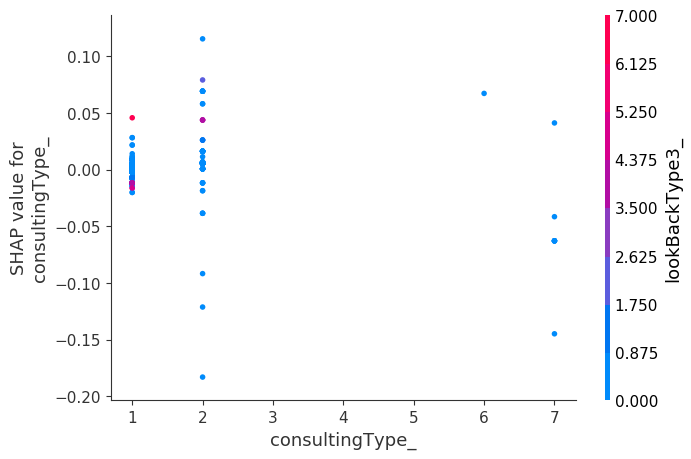

In [290]:
shap.dependence_plot('consultingType_', features = x_test, shap_values = np.array(shap_values)[0])

In [881]:
shap.force_plot(x_test.iloc[:10,:], np.array(shap_values)[:10,:])

In [468]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [77]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [78]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [79]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [388]:
classes = rfc.classes_
classes
# 7
#6 after drop the category '5'

array([1, 2, 3, 4, 5, 6])

invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

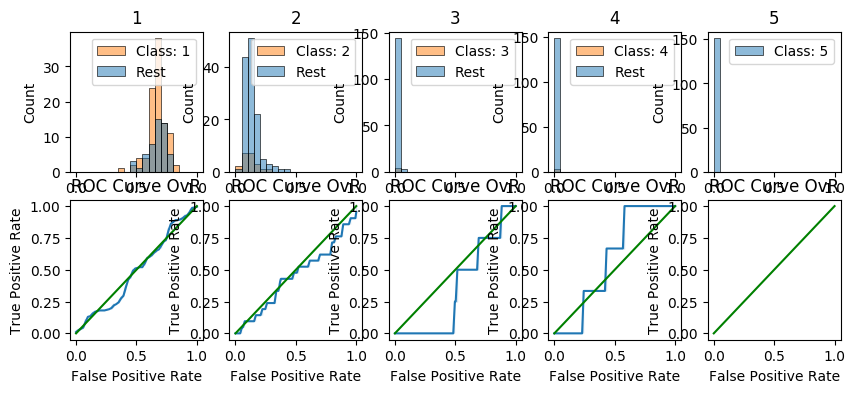

In [469]:
y_proba = stacking.predict_proba(x_test)

# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 4))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = x_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test.lookAheadType_.values]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [ ]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

1 ROC AUC OvR: 0.5260
2 ROC AUC OvR: 0.4627
average ROC AUC OvR: 0.4943


In [433]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
y_one_hot = label_binarize(y = y_test, classes= model.classes_)  #装换成类似二进制的编码

roc_auc_score(y_one_hot, y_proba, labels = classes, multi_class = 'ovr', average = 'micro')

0.7913588006651461

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
class Multi_class_evaluation(object):
    # 输入原始值，预测值，分类数量
    def __init__(self, y, y_pred, n_class=2, flag=None):
        self.n_class = n_class
        self.flag = flag
        # 构造数据矩阵n*分类数量        
        def datas():
            cols_name = []
            for i in range(self.n_class):
                cols_name.append('v'+str(i))
                
            def f(v):
                vv = []
                for i in range(self.n_class):
                    if v==i:
                        vv.append(1)
                    else:
                        vv.append(0)
                                
                return pd.Series(vv)
        
            self.y = pd.DataFrame()
            self.y[cols_name] = y[self.flag].apply(lambda x:f(x)) 
        datas()
        self.y = self.y.to_numpy()
        self.y_pred = y_pred
    
    # 计算ROC和AUC
    def calculation_ROC_AUC(self):
        # Compute ROC curve and ROC area for each class
        self.fpr = dict()
        self.tpr = dict()
        self.roc_auc = dict()
        for i in range(self.n_class):
            self.fpr[i], self.tpr[i], _ = roc_curve(self.y[:, i], self.y_pred[:, i])
            self.roc_auc[i] = auc(self.fpr[i], self.tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        self.fpr["micro"], self.tpr["micro"], _ = roc_curve(self.y.ravel(), self.y_pred.ravel())
        self.roc_auc["micro"] = auc(self.fpr["micro"], self.tpr["micro"])        
    #默认是多分类    
    def draw_ROC(self,multi_class=None):                 
        # First aggregate all false positive rates
        if multi_class==None:
            all_fpr = np.unique(np.concatenate([self.fpr[i] for i in range(self.n_class)]))
            
            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(self.n_class):
                mean_tpr += interp(all_fpr, self.fpr[i], self.tpr[i])
            
            # Finally average it and compute AUC
            mean_tpr /= self.n_class
            
            self.fpr["macro"] = all_fpr
            self.tpr["macro"] = mean_tpr
            self.roc_auc["macro"] = auc(self.fpr["macro"], self.tpr["macro"])
            
            # Plot all ROC curves
            plt.figure()
            lw=2 #折线宽度
            plt.plot(self.fpr["micro"], self.tpr["micro"],
                     label='micro-average ROC curve (area = {0:0.4f})'
                           ''.format(self.roc_auc["micro"]),
                     color='deeppink', linestyle=':', linewidth=4)
            
            plt.plot(self.fpr["macro"], self.tpr["macro"],
                     label='macro-average ROC curve (area = {0:0.4f})'
                           ''.format(self.roc_auc["macro"]),
                     color='navy', linestyle=':', linewidth=4)
            
            colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
            for i, color in zip(range(self.n_class), colors):
                plt.plot(self.fpr[i], self.tpr[i], color=color, lw=lw,
                         label='ROC curve of class {0} (area = {1:0.4f})'
                         ''.format(i, self.roc_auc[i]))
        else:
            plt.figure()
            lw=2 #折线宽度
            plt.plot(self.fpr[multi_class], self.tpr[multi_class],
                     label='ROC curve of class {0} (area = {1:0.4f})'
                           ''.format(multi_class, self.roc_auc[multi_class]),
                     color='deeppink')            
        
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

In [ ]:
Multi_class_evaluation(y_test, y_proba, 3)

ovo

In [91]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])
classes_combinations

[[0, 1], [1, 0], [0, 2], [2, 0], [1, 2], [2, 1]]

In [92]:
len(classes_combinations)

6

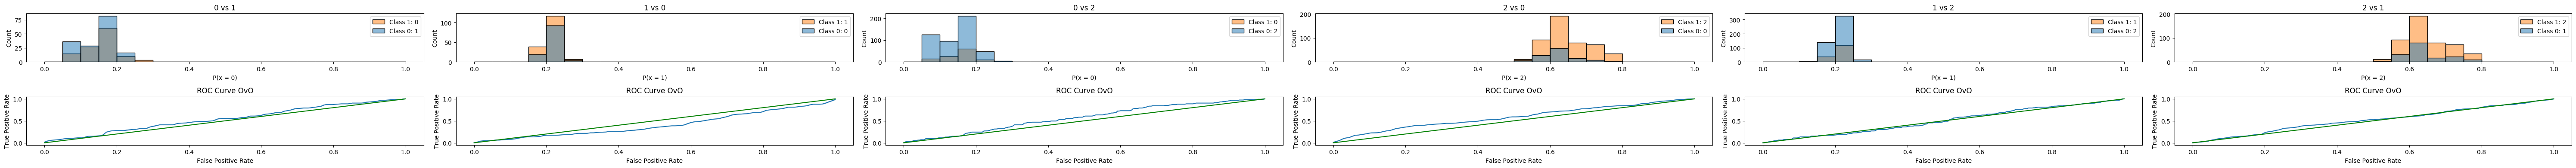

In [93]:
# Plots the Probability Distributions and the ROC Curves One vs ONe
plt.figure(figsize = (60, 4))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = str(c1) + " vs " +str(c2)
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = x_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_proba[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [94]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

0 vs 1 ROC AUC OvO: 0.5466
1 vs 0 ROC AUC OvO: 0.4130
0 vs 2 ROC AUC OvO: 0.5719
2 vs 0 ROC AUC OvO: 0.5853
1 vs 2 ROC AUC OvO: 0.5023
2 vs 1 ROC AUC OvO: 0.5183
average ROC AUC OvO: 0.5229


In [208]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
# roc_auc_score(y_one_hot, y_proba, labels = classes, multi_class = 'ovo', average = 'micro')

0.9383666510683145

transformer BERT multi-classification task

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader, Dataset

device = 'cuda' if torch.cuda.is_available() else "cpu"
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.seqs, self.seq_masks, self.seq_segments, self.labels = self.get_input(dataframe)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.seqs[idx], self.seq_masks[idx], self.seq_segments[idx], self.labels[idx]

    def get_input(self, dataframe):
        df = dataframe
        df = df.drop('id', axis=1)
        text = df['comment_text'].values.tolist()
        labels = df.iloc[:, 1:].values
        output = self.tokenizer(text, padding=True, return_tensors='pt', truncation=True,
                                max_length=self.max_len)
        return output['input_ids'], output['token_type_ids'], output['attention_mask'], torch.Tensor(labels).type(
            torch.float)

In [ ]:
# 划分测试集以及训练集
df = pd.read_csv('train.csv')
train_size = 0.8
train_data = df.sample(frac=0.8, random_state=200)
test_data = df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)
tokenizer = BertTokenizer.from_pretrained('model/', do_lower_case=True)
# pytorch模式加载数据集
training_set = MultiLabelDataset(train_data, tokenizer, 128)
testing_set = MultiLabelDataset(test_data, tokenizer, 128)
# 加载到dataLoader中
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
train_loader = DataLoader(training_set, shuffle=True, batch_size=TRAIN_BATCH_SIZE)
test_loader = DataLoader(testing_set, shuffle=True, batch_size=VALID_BATCH_SIZE)

### 针对预训练模型进行修改

In [ ]:
# 模型修改
class DistlBERTClass(nn.Module):
    def __int__(self):
        super(DistlBERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('model/')
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_msak, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_msak)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
model = DistlBERTClass()
model.to(device)

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
LEARNING_RATE = 1e-05
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
# 定义训练器
def train(epoch):
    model.train()
    for _, (ids,attention_mask,token_type_ids,labels) in tqdm(enumerate(train_loader, 0)):
        # print(data)
        ids = ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = labels.to(device)
        outputs = model(ids, attention_mask, token_type_ids)
        # 将模型的参数梯度初始化为0
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _ % 5000 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        optimizer.zero_grad()
        # 反向传播计算梯度
        loss.backward()
        # 更新所有参数
        optimizer.step()
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, (ids,attention_mask,token_type_ids,labels) in tqdm(enumerate(testing_loader, 0)):
            ids = ids.to(device, dtype = torch.long)
            mask = attention_mask.to(device, dtype = torch.long)
            token_type_ids = token_type_ids.to(device, dtype = torch.long)
            targets = labels.to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
# 训练
print('开始训练')
EPOCHS = 4
for epoch in range(EPOCHS):
    train(epoch)
import numpy as np
outputs, targets = validation(test_loader)

final_outputs = np.array(outputs) >=0.5
from sklearn import metrics
val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")
ddf=pd.DataFrame(final_outputs,columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate'])
ddf=ddf.astype('int')
ddf.to_csv('最终结果.csv',index=None)

LSTM for Sequence Classification

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(7)

In [ ]:
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [ ]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

LSTM with Dropout to avoid overfitting

In [ ]:
# model = Sequential()
# model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
# model.add(Dropout(0.2))
# model.add(LSTM(100))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

BiLSTM

In [ ]:
# model = Sequential()
# model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
# model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
# model.add(Dense(1, activation='sigmoid'))

LSTM + CNN

In [ ]:
# model = Sequential()
# model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(100))
# model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))